<a href="https://colab.research.google.com/github/rpizarrog/innovacion-empresarial/blob/main/notebook_python/Evaluaci%C3%B3n_de_modelos_de_regresi%C3%B3n_multivariada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor: **Rubén Pizarro Gurrola**

**Marzo 2025**


# Objetivo

Construir y evaluar modelos de
regresión en la prediccón de rendimiento académico con datos de habilidades blandas en estudiantes de educación superior.





# Metodología


## Cargar librerías



In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Tal vez se use
from scipy.stats import kstest, shapiro, anderson, spearmanr
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

import math

from sklearn.model_selection import train_test_split
# Librerías para modelos de regresión
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge

## Cargar funciones


In [64]:
# @title Default title text
def f_cargar_datos(ruta_archivo, tipo='csv', hoja_excel=None, separador=','):
    """
    Carga datos desde un archivo especificado.

    Parámetros:
    - ruta_archivo (str): Ruta del archivo a cargar.
    - tipo (str): Tipo de archivo a cargar ('csv', 'excel', 'txt'). Por defecto es 'csv'.
    - hoja_excel (str): Nombre o índice de la hoja, en caso de ser un archivo Excel. Por defecto es None.
    - separador (str): Separador para archivos de texto o CSV. Por defecto es ','.

    Retorna:
    - DataFrame: Un DataFrame con los datos cargados.
    """
    try:
        if tipo == 'csv':
            datos = pd.read_csv(ruta_archivo, sep=separador)
        elif tipo == 'excel':
            datos = pd.read_excel(ruta_archivo, sheet_name=hoja_excel)
        elif tipo == 'txt':
            datos = pd.read_csv(ruta_archivo, sep=separador)
        else:
            raise ValueError("El tipo de archivo no es soportado. Use 'csv', 'excel' o 'txt'.")

        print("Datos cargados correctamente.")
        return datos

    except FileNotFoundError:
        print(f"Error: El archivo '{ruta_archivo}' no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error al cargar los datos: {e}")


def f_eliminar_columnas(datos, columnas):
    """
    Elimina las columnas especificadas de un DataFrame.

    Parámetros:
    - datos (DataFrame): El DataFrame de entrada.
    - columnas (list): Lista de nombres de columnas a eliminar.

    Retorna:
    - DataFrame: El DataFrame sin las columnas especificadas.
    """
    try:
        # Verificar si todas las columnas existen
        columnas_existentes = [col for col in columnas if col in datos.columns]
        if not columnas_existentes:
            print("Ninguna de las columnas especificadas existe en el DataFrame.")
            return datos

        # Eliminar las columnas especificadas
        datos_actualizado = datos.drop(columns=columnas_existentes)
        print(f"Columnas eliminadas correctamente: {columnas_existentes}")
        return datos_actualizado

    except Exception as e:
        print(f"Error al eliminar las columnas: {e}")
        return datos


def f_tabla_frecuencia(datos, columna):
    """
    Genera una tabla de frecuencias para datos cualitativos.

    Parámetros:
    - datos (DataFrame): El DataFrame de entrada.
    - columna (str): El nombre de la columna cualitativa a analizar.

    Retorna:
    - DataFrame: Tabla de frecuencias con columnas de frecuencia absoluta, relativa y acumulada.
    """
    try:
        # Contar frecuencias absolutas
        frecuencia = datos[columna].value_counts().reset_index()
        frecuencia.columns = [columna, 'Frecuencia_Absoluta']

        # Calcular frecuencia relativa y porcentual
        total = frecuencia['Frecuencia_Absoluta'].sum()
        frecuencia['Frecuencia_Relativa'] = frecuencia['Frecuencia_Absoluta'] / total
        frecuencia['Frecuencia_Porcentual'] = frecuencia['Frecuencia_Relativa'] * 100

        # Calcular frecuencias acumuladas
        frecuencia['Frecuencia_Acumulada'] = frecuencia['Frecuencia_Absoluta'].cumsum()
        frecuencia['Frecuencia_Porcentual_Acumulada'] = frecuencia['Frecuencia_Porcentual'].cumsum()

        return frecuencia

    except KeyError:
        print(f"Error: La columna '{columna}' no existe en el DataFrame.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

def f_histograma(datos, variable, barras=10):
    # Convertir la variable a un array para cálculos estadísticos
    valores = np.array(datos[variable])

    # Calcular medidas estadísticas
    media = np.mean(valores)
    mediana = np.median(valores)
    # moda = stats.mode(valores)[0][0]

    # Crear el histograma
    plt.figure(figsize=(8, 6))
    plt.hist(valores, bins=barras, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
    # plt.axvline(moda, color='blue', linestyle='--', label=f'Moda: {moda:.2f}')

    # Etiquetas y título
    plt.title('Histograma con Media, Mediana')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

def f_barra(datos, variable, color='lightblue', mostrar='primeros'):
    # Contar la frecuencia de cada categoría
    frecuencias = datos[variable].value_counts()

    # Verificar cuántas categorías hay
    if len(frecuencias) > 10:
        if mostrar == 'primeros':
            frecuencias = frecuencias.head(10)  # Primeras 10 categorías
        elif mostrar == 'ultimos':
            frecuencias = frecuencias.tail(10)  # Últimas 10 categorías

    # Crear el diagrama de barras
    plt.figure(figsize=(8, 6))
    barras = plt.bar(frecuencias.index, frecuencias.values, color=color, edgecolor='black', alpha=0.7)

    # Agregar etiquetas y título
    plt.xlabel('Categorías')
    plt.ylabel('Frecuencia')
    plt.title(f'Diagrama de Barras de {variable} (Mostrando {mostrar} 10)')
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor visualización si son largas

    # Mostrar valores encima de cada barra
    for barra in barras:
        plt.text(barra.get_x() + barra.get_width() / 2, barra.get_height(),
                 f'{int(barra.get_height())}', ha='center', va='bottom', fontsize=10)

    # Mostrar el gráfico
    plt.show()

# función para ver diagrmas de barras multiples variables
def f_barra_multiple_matriz(datos, variables=None, color='lightblue', mostrar='primeros'):
    # Obtener columnas categóricas si no se especificaron
    if variables is None:
        variables = datos.select_dtypes(include=['object', 'category']).columns.tolist()

    # Verificar si hay variables categóricas
    if not variables:
        print("No hay variables categóricas para graficar.")
        return

    # Determinar la disposición de la matriz según el número de columnas categóricas
    num_columnas = len(variables)
    if num_columnas <= 4:
        filas, columnas = 2, 2
    elif num_columnas <= 9:
        filas, columnas = 3, 3
    elif num_columnas <= 16:
        filas, columnas = 4, 4
    else:
        columnas = 4
        filas = math.ceil(num_columnas / columnas)

    # Crear la figura y subplots
    fig, axes = plt.subplots(filas, columnas, figsize=(columnas * 5, filas * 4))
    axes = axes.flatten()  # Convertir los ejes en una lista para indexar fácilmente

    # Validar el argumento 'mostrar'
    if mostrar not in ['primeros', 'ultimos']:
        mostrar = 'primeros'

    # Generar gráficos
    for i, variable in enumerate(variables):
        if i >= len(axes):  # Prevenir error de índice en subplots
            break

        # Contar la frecuencia de cada categoría
        frecuencias = datos[variable].value_counts()
        total = frecuencias.sum()
        porcentajes = (frecuencias / total) * 100  # Convertir a porcentaje

        # Mostrar solo las primeras o últimas 10 categorías si hay más de 10
        if len(frecuencias) > 10:
            if mostrar == 'primeros':
                frecuencias = frecuencias.head(10)
                porcentajes = porcentajes.head(10)
            elif mostrar == 'ultimos':
                frecuencias = frecuencias.tail(10)
                porcentajes = porcentajes.tail(10)

        # Dibujar el diagrama de barras en el subplot correspondiente
        axes[i].bar(frecuencias.index, frecuencias.values, color=color, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{variable}')
        axes[i].set_xlabel('Categorías')
        axes[i].set_ylabel('Frecuencia')
        axes[i].tick_params(axis='x', rotation=45)

        # Mostrar valores como porcentajes sobre las barras
        for j, (valor, porcentaje) in enumerate(zip(frecuencias.values, porcentajes)):
            axes[i].text(j, valor, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=8)

    # Ocultar subplots vacíos
    for ax in axes[num_columnas:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()




# Función que visualiza múltiples histogramas de variables numéricas
def f_histograma_multiple_matriz(datos, columnas=None, bins=10, color='skyblue'):
    """
    Genera múltiples histogramas organizados en una matriz dependiendo del número de variables numéricas seleccionadas.

    Parámetros:
    datos (pd.DataFrame): DataFrame que contiene los datos.
    columnas (list or None): Lista de columnas a graficar. Si es None, selecciona todas las columnas numéricas.
    bins (int): Número de intervalos para los histogramas.
    color (str): Color de los histogramas.

    Retorno:
    Visualiza múltiples histogramas organizados automáticamente.
    """
    # Si no se especifican columnas, selecciona todas las numéricas
    if columnas is None:
        columnas = datos.select_dtypes(include=['number']).columns.tolist()

    # Determinar el número de filas y columnas (3 o 4 columnas dependiendo del número de variables)
    n_vars = len(columnas)
    n_cols = 4 if n_vars > 6 else 3  # Si hay más de 6 variables, usa 4 columnas
    n_rows = math.ceil(n_vars / n_cols)  # Calcular el número de filas necesarias

    # Configuración de subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Aplanar para fácil iteración

    # Graficar cada variable
    for i, variable in enumerate(columnas):
        axes[i].hist(datos[variable].dropna(), bins=bins, color=color, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Histograma de {variable}')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Frecuencia')

    # Eliminar subplots vacíos si hay menos gráficos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Función para graficar varios diagrmas de caja de variables numéricas
def f_diagrama_caja_matriz(datos, columnas=None):
    """
    Genera múltiples diagramas de caja organizados en una matriz de hasta 4 por fila.

    Parámetros:
    datos (pd.DataFrame): DataFrame con las variables numéricas.
    columnas (list or None): Lista de columnas a graficar. Si es None, selecciona todas las numéricas.

    Salida:
    Muestra diagramas de caja organizados automáticamente.
    """
    # Si no se especifican columnas, selecciona todas las numéricas
    if columnas is None:
        columnas = datos.select_dtypes(include=['number']).columns.tolist()

    # Número total de variables a graficar
    n_vars = len(columnas)

    # Determinar número de filas y columnas (máximo 4 columnas por fila)
    n_cols = 4  # Fijamos el máximo en 4 columnas por fila
    n_rows = math.ceil(n_vars / n_cols)  # Calculamos las filas necesarias

    # Crear la figura y los subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Aplanar la matriz de subplots para iterar fácilmente

    # Graficar cada variable numérica
    for i, variable in enumerate(columnas):
        datos_var = datos[variable].dropna().values  # Eliminar valores NaN

        # Crear diagrama de caja
        axes[i].boxplot(datos_var, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
        axes[i].set_title(f'Diagrama de Caja de {variable}')
        axes[i].set_xlabel('Valor')

        # Calcular cuartiles
        q1, q2, q3 = np.percentile(datos_var, [25, 50, 75])

        # Dibujar líneas de cuartiles
        axes[i].axvline(x=q1, color='blue', linestyle='--', linewidth=1, alpha=0.7, label=f'Q1: {q1:.2f}')
        axes[i].axvline(x=q2, color='red', linestyle='--', linewidth=1, alpha=0.7, label=f'Mediana: {q2:.2f}')
        axes[i].axvline(x=q3, color='blue', linestyle='--', linewidth=1, alpha=0.7, label=f'Q3: {q3:.2f}')

        axes[i].legend(fontsize=8)

    # Eliminar subplots vacíos si hay menos gráficos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


## Funciones para transformar datos
# Definir la función que convierte una lista o arreglo a valores numéricos
def f_convertir_numeros(valores):
    # Convertir los valores a numéricos, forzando los no convertibles a NaN
    numericos = pd.to_numeric(valores, errors='coerce')
    return numericos

# Definen una función que convierte valores numéricos a valores absolutos
def f_convertir_absoluto (valores):
  return np.abs(valores)

# Función median con pandas la función median()
def f_mediana(valores):
  # Mediana excluyendo
  mediana = valores.median()
  return mediana

def f_convertir_mediana(valores):
    # Convertir la entrada a una Serie de Pandas si no lo es
    if not isinstance(valores, pd.Series):
        valores = pd.Series(valores)

    # Convertir todos los valores a numéricos, forzando los no convertibles a NaN
    valores_numericos = pd.to_numeric(valores, errors='coerce')

    # Calcular la mediana de los valores numéricos, excluyendo los NaN
    mediana = valores_numericos.median()

    # Reemplazar los NaN con la mediana
    numeros = valores_numericos.fillna(mediana)

    return numeros


# Función que determina cuartiles
def f_cuartiles_quantile(datos):
  q1 = np.percentile(datos, 25)
  q2 = np.percentile(datos, 50)
  q3 = np.percentile(datos, 75)
  return q1, q2, q3

# Función que construye diagrama de caja
def f_diagrama_caja (datos, contexto):
  plt.boxplot(datos, vert=False)
  plt.xlabel(contexto)
  plt.ylabel('Valor')
  plt.title('Diagrama de Caja')

  # Calculando cuartiles d ela funci´pn previamente creada
  q1, q2, q3= f_cuartiles_quantile(datos)
  # Añadir leyendas para los cuartiles
  plt.axvline(x=q1, color='blue', linestyle='--', linewidth=1, label=f'Q1: {q1:.2f}')
  plt.axvline(x=q2, color='blue', linestyle='--', linewidth=1, label=f'Q2:Mediana: {q2:.2f}')
  plt.axvline(x=q3, color='blue', linestyle='--', linewidth=1, label=f'Q3: {q3:.2f}')

  # Añadir leyenda adicional
  plt.legend()

  plt.show()

# Funcíon para modificar atípicos por la mediana
# Se hacen varias iteraciones al menos una para
# eliminar porque tal vez sigan quedando y esto garantiza quitarlos.
def f_modificar_atipicos(datos, max_iter=10):
    """
    Reemplaza los valores atípicos en una serie de datos por la mediana utilizando
    el criterio del rango intercuartil (IQR). Se ejecuta de manera iterativa
    hasta que no haya valores atípicos o se alcance el máximo de iteraciones.

    Parámetros:
    datos (pd.Series o np.array): Datos a procesar.
    max_iter (int): Número máximo de iteraciones para eliminar atípicos.

    Retorna:
    np.array o pd.Series: Datos con valores atípicos reemplazados por la mediana.
    """

    datos = np.array(datos)  # Convertir a array para manipulación
    iter_count = 0  # Contador de iteraciones

    while iter_count < max_iter:
        q1 = np.percentile(datos, 25)
        q3 = np.percentile(datos, 75)
        RI = q3 - q1  # Rango intercuartílico
        limite_inferior = q1 - 1.5 * RI
        limite_superior = q3 + 1.5 * RI
        mediana = np.median(datos)  # Calcular la mediana

        # Identificar valores atípicos
        atipicos = (datos < limite_inferior) | (datos > limite_superior)

        # Si ya no hay valores atípicos, terminamos
        if not np.any(atipicos):
            break

        # Reemplazar valores atípicos con la mediana
        datos[atipicos] = mediana
        iter_count += 1  # Incrementar contador de iteraciones

    return datos



# Convertir todos los valores a mayúsculas para estandarizar la columna.
def f_convertir_MAYUSCULAS(valores):
  # 1. Convertir todos los valores a mayúsculas
  valores = valores.str.upper()
  return valores

# Función para convertir primera MAYUSCULA y resto minúscula
def f_convertir_MAYUSCULAS_minusculas(valores):
    # Convertir la primera letra de cada palabra a mayúscula y el resto a minúscula
    valores = valores.str.capitalize()
    return valores

def f_reemplazar_generos_moda (valores):
  moda_generos = valores.mode()[0]

  valores.fillna(moda_generos, inplace=True)

  return valores

# Función que debe modifiar un valor de acuerdo a la cadena que mas se le parezca
def f_modificar_inicial (valores):
  # Mapear cualquier valor que sea claramente 'M' o 'F' a 'MASCULINO' o 'FEMENINO'
  valores = valores.replace({'M': 'MASCULINO', 'F': 'FEMENINO'})

  # Debe identificar los valores únicos los dos que mas se repitan
  # por ejemplo FEMENINO Y MASCULINO
  # De cada valor si hay una ler F es FEMENINO
  # De cada valor si hay una ler M es MASCULINO
  # De cada valor si se parece por ejemplo GEMENINO se parece a FEMENINO
  # De cada valor si se parece por ejemplo SASCULINO se parece a MASCULINO
  return valores



# Función que modifica valores similares
def f_modificar_parecidos(valores, opciones=['FEMENINO', 'MASCULINO'], umbral=50):
    """
    Estandariza los valores de género en una lista o columna de DataFrame a 'FEMENINO' o 'MASCULINO' basado en la similitud.

    Parámetros:
    - valores: Una lista o Serie de pandas con los valores de género a estandarizar.
    - opciones: Una lista de valores aceptados a los que se intentará hacer coincidir los valores.
    - umbral: El umbral de coincidencia para considerar una equivalencia (0-100).

    Retorna:
    Una lista o Serie de pandas con los valores estandarizados.
    """
    # Función para estandarizar un único valor
    def estandarizar_valor(valor):
        if valor is None:  # Verifica si el valor es None antes de proceder
            return valor
        mejor_coincidencia, puntaje = process.extractOne(valor.upper(), opciones)
        return mejor_coincidencia if puntaje > umbral else valor

    # Aplicar la estandarización a cada valor en la lista o Serie
    if isinstance(valores, pd.Series):
        return valores.apply(estandarizar_valor)
    else:
        return [estandarizar_valor(valor) for valor in valores]

# Función mejorada con densidad en histogramas
def f_histograma_multiple_matriz_densidad(datos, columnas=None, bins=10, color='skyblue'):
    # Si no se especifican columnas, selecciona todas las numéricas
    if columnas is None:
        columnas = datos.select_dtypes(include=['number']).columns.tolist()

    # Determinar el número de filas y columnas (3 o 4 columnas dependiendo del número de variables)
    n_vars = len(columnas)
    n_cols = 4 if n_vars > 6 else 3  # Si hay más de 6 variables, usa 4 columnas
    n_rows = math.ceil(n_vars / n_cols)  # Calcular el número de filas necesarias

    # Configuración de subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Aplanar para fácil iteración

    # Graficar cada variable con histograma y densidad
    for i, variable in enumerate(columnas):
        # sns.histplot(datos[variable].dropna(), bins=bins, kde=True, color=color, edgecolor='black', alpha=0.7, ax=axes[i])
        sns.histplot(datos[variable].dropna(), bins=bins, kde=True, color=color, edgecolor='black', alpha=0.7,
             line_kws={'color': 'red'}, ax=axes[i])
        axes[i].set_title(f'Histograma de {variable}')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Frecuencia')

    # Eliminar subplots vacíos si hay menos gráficos que subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



# Función para visualizar qqplot de varias variables numéricas
def f_matriz_qqplots(datos_numericos):
  # Determinar el tamaño de la cuadrícula de visualización
  num_vars = len(datos_numericos.columns)
  if num_vars <= 4:
    filas, columnas = 2, 2
  elif num_vars <= 9:
    filas, columnas = 3, 3
  else:
    filas, columnas = 4, 4

  # Crear figura y subplots
  fig, axes = plt.subplots(filas, columnas, figsize=(columnas * 5, filas * 5))
  axes = axes.flatten()

  # Generar los Q-Q plots para cada variable numérica
  for i, col in enumerate(datos_numericos.columns):
    stats.probplot(datos_numericos[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"Q-Q Plot de {col}")
    axes[i].set_xlabel("Cuantiles teóricos")
    axes[i].set_ylabel("Cuantiles de la muestra")

  # Ocultar ejes no usados si hay menos variables que subplots
  for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

# Aplicar la prueba de Kolmogorov-Smirnov para cada variable numérica
def f_prueba_kolmovorov(datos_numericos):

  resultados_ks = {}

  for columna in datos_numericos.columns:
    stat_ks, p_ks = kstest(datos_numericos[columna], 'norm')
    resultados_ks[columna] = {
        "Kolmogorov-Smirnov Statistic": stat_ks,
        "p-value": p_ks
    }

  # Convertir a DataFrame
  resultados = pd.DataFrame(resultados_ks).T
  print (resultados)

# Aplica la prueba de Shapiro-Wilk para evaluar la normalidad en cada variable numérica de un DataFrame.
def f_prueba_shapiro(datos_numericos):
    resultados_shapiro = {}

    for columna in datos_numericos.columns:
        stat_shapiro, p_shapiro = shapiro(datos_numericos[columna])
        resultados_shapiro[columna] = {
            "Shapiro-Wilk Statistic": stat_shapiro,
            "p-value": p_shapiro
        }

    # Convertir a DataFrame
    resultados = pd.DataFrame(resultados_shapiro).T

    print(resultados)

# Prueba Anderson DArling
def f_Anderson_Darling(datos_numericos):
    resultados_ad = {}

    for columna in datos_numericos.columns:
        resultado = anderson(datos_numericos[columna], dist='norm')  # Evaluar contra distribución normal
        stat_ad = resultado.statistic
        crit_values = resultado.critical_values
        sig_levels = resultado.significance_level

        resultados_ad[columna] = {
            "Anderson-Darling Statistic": stat_ad,
            "Critical Values (15%)": crit_values[0],
            "Critical Values (10%)": crit_values[1],
            "Critical Values (5%)": crit_values[2],
            "Critical Values (2.5%)": crit_values[3],
            "Critical Values (1%)": crit_values[4]
        }

    # Convertir a DataFrame
    resultados = pd.DataFrame(resultados_ad).T

    print(resultados)

# Modificar la función para mostrar los valores con 4 decimales
def f_correlaciones_Pearson(datos):
    # Calcular la matriz de correlación de Pearson
    correlaciones = datos.corr(method='pearson').round(4)

    # Generar el heatmap de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
    plt.title("Matriz de Correlación de Pearson")
    plt.show()

    return correlaciones

# Definir la función f_correlaciones_Spearman
def f_correlaciones_Spearman(datos):
    # Calcular la matriz de correlación de Spearman
    correlaciones = datos.corr(method='spearman').round(4)

    # Generar el heatmap de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".4f", linewidths=0.5)
    plt.title("Matriz de Correlación de Spearman")
    plt.show()

    return correlaciones

def f_dispersion_matriz(datos, independientes, dependiente):

    num_vars = len(independientes)
    max_columns = 3
    num_rows = int(np.ceil(num_vars / max_columns))

    fig, axes = plt.subplots(num_rows, max_columns, figsize=(16, 4 * num_rows))
    axes = axes.flatten()

    for i, var in enumerate(independientes):
        ax = axes[i]

        # Calcular correlaciones de Pearson y Spearman
        pearson_corr = np.corrcoef(datos[var], datos[dependiente])[0, 1]
        spearman_corr, _ = spearmanr(datos[var], datos[dependiente])

        # Graficar dispersión con línea de regresión
        sns.regplot(x=datos[var], y=datos[dependiente], ax=ax, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

        # Etiquetas y título con coeficientes de correlación
        ax.set_xlabel(var)
        ax.set_ylabel(dependiente)
        ax.set_title(f"{var} vs {dependiente}\nPearson: {pearson_corr:.3f} | Spearman: {spearman_corr:.3f}")

    # Eliminar ejes vacíos si hay menos de 4 variables
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Definir una función para calcular el VIF
def f_calcular_vif(datos):
    vif = pd.DataFrame()
    vif["Variable"] = datos.columns
    vif["VIF"] = [variance_inflation_factor(datos.values, i) for i in range(datos.shape[1])]
    return vif

# Función para escalar datos
def f_escalar(datos, variable):
    """
    Escala una columna numérica de un DataFrame usando la fórmula min-max:
    (x - min(x)) / (max(x) - min(x))

    """
    if variable not in datos.columns:
        raise ValueError(f"La columna '{variable}' no existe en el DataFrame.")

    if not pd.api.types.is_numeric_dtype(datos[variable]):
        raise ValueError(f"La columna '{variable}' no es numérica.")

    min_x = datos[variable].min()
    max_x = datos[variable].max()

    if min_x == max_x:
        raise ValueError(f"La columna '{variable}' tiene valores constantes, no se puede escalar.")

    escalado = (datos[variable] - min_x) / (max_x - min_x)
    return np.round(escalado, 4)

# Función para normalizar datos
def f_normalizar(datos, variable):
    """
    Normaliza una columna numérica de un DataFrame usando la fórmula z-score:
    (x - media) / desviación estándar

    """
    if variable not in datos.columns:
        raise ValueError(f"La columna '{variable}' no existe en el DataFrame.")

    if not pd.api.types.is_numeric_dtype(datos[variable]):
        raise ValueError(f"La columna '{variable}' no es numérica.")

    media_x = datos[variable].mean()
    std_x = datos[variable].std()

    if std_x == 0:
        raise ValueError(f"La columna '{variable}' tiene desviación estándar cero, no se puede normalizar.")

    normalizado = (datos[variable] - media_x) / std_x
    return np.round(normalizado)

# Función para evaluar un modelo y guardar los resultados en el diccionario
def f_evaluar_modelo(modelo, X_test, y_test, nombre_modelo):
    # Realizar predicciones
    y_pred = modelo.predict(X_test)

    # Calcular métricas
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)  # Número de muestras en el conjunto de validación
    p = X.shape[1]  # Número de características
    r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    # Guardar resultados en el diccionario que es variable global
    resultados[nombre_modelo] = {
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "R² Ajustado": r2_ajustado
    }

    f_diferencias_reales_predicciones(y_test, y_pred, rmse, r2_ajustado, nombre_modelo)

    # Mostrar resultados
    print(f"\n=== {nombre_modelo} ===")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"R² Ajustado: {r2_ajustado:.4f}")

# Función para entrenar y evaluar modelos polinomiales
def f_evaluar_modelo_polinomial(grado, X_train, X_test, y_train, y_test, nombre_modelo):
    # Crear características polinomiales
    poly = PolynomialFeatures(degree=grado)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Entrenar el modelo de regresión lineal con características polinomiales
    modelo_p = LinearRegression()
    modelo_p.fit(X_train_poly, y_train)

    # Evaluar el modelo
    return f_evaluar_modelo(modelo_p, X_test_poly, y_test, nombre_modelo)


# Función que crea gráfico de diferencias entre predicciones y valores reales
# del conjunto de datos de validación
def f_diferencias_reales_predicciones(y_test, y_pred, rmse, r2_ajustado, nombre_modelo, gr=None):
    """
    Crea un gráfico de comparación entre valores reales y predichos,
    y muestra las métricas R² ajustado y RMSE.

    Parámetros:
    - y_test: Valores reales de la variable objetivo.
    - y_pred: Valores predichos por el modelo.
    - nombre_modelo: Nombre del modelo para el título del gráfico.
    - ax: Eje de matplotlib para dibujar el gráfico. Si es None, se crea uno nuevo.

    Retorna:
    - ax: Eje de matplotlib con el gráfico dibujado.
    """

  # Si no se proporciona un eje, crear uno nuevo
    if gr is None:
        fig, gr = plt.subplots(figsize=(10, 5))

    # Crear gráfico de comparación entre valores reales y predichos
    gr.plot(y_test.values, label="Valores Reales", color="blue", linestyle="-", linewidth=2)
    gr.plot(y_pred, label="Predicciones", color="red", linestyle="-", linewidth=2)

    # Agregar métricas en el gráfico
    # gr.text(2, max(y_test) * 0.4, f"R² Ajustado: {r2_ajustado:.4f}", fontsize=10, color="black")
    # gr.text(2, max(y_test) * 0.5, f"RMSE: {rmse:.2f}", fontsize=10, color="black")

    # Configuración del gráfico
    gr.set_xlabel("Índice de Observaciones")
    gr.set_ylabel("Rendimiento Académico") # Variable dependiente
    gr.set_title(f"{nombre_modelo} \n(R² Ajustado:{r2_ajustado:.4f}; RMSE:{rmse:.2f})")
    gr.legend()
    gr.grid(True)

    # Obtener la figura del eje y mostrarla
    gr.figure.show()

    # Almacena el gráfico en la variable global
    # Guardar los graficos de diferencias
    # graficos_globales[nombre_modelo] = gr
    gr_diferencias_predicciones[nombre_modelo] = gr  # Diccionario global para almacenar los gráficos


    # Obtener la figura del eje y mostrarla
    # gr.figure.show()
    # Retornar el eje para su uso posterior
    # return gr


def f_diferencias_matriz(gr_diferencias_predicciones):
    """
    Muestra los gráficos de diferencias entre predicciones y valores reales en una matriz.

    Parámetros:
    - gr_diferencias_predicciones: Diccionario donde las claves son los nombres de los modelos
      y los valores son los objetos de eje de matplotlib.
    """

    # Número de gráficos y dimensiones de la matriz
    num_graficos = len(gr_diferencias_predicciones)
    filas = (num_graficos + 2) // 3  # Calcula el número de filas necesarias
    columnas = min(num_graficos, 3)  # Máximo de 3 columnas

    # Crea la figura y los subplots
    fig, axes = plt.subplots(filas, columnas, figsize=(15, 5 * filas))  # Ajusta el tamaño de la figura

    # Asegura que axes sea una matriz
    if num_graficos == 1:
        axes = [axes]

    # Itera sobre los gráficos y los agrega a los subplots
    for i, (nombre_modelo, grafico) in enumerate(gr_diferencias_predicciones.items()):
        fila = i // columnas
        columna = i % columnas

        # Obtiene el eje del gráfico y lo copia al subplot correspondiente
        ax = axes[fila][columna] if num_graficos > 1 else axes[columna]

        # Copia los elementos del grafico al subplot
        for line in grafico.get_lines():
            ax.plot(line.get_xdata(), line.get_ydata(), color=line.get_color(), label=line.get_label())
        for text in grafico.texts:
            ax.text(text.get_position()[0], text.get_position()[1], text.get_text(), fontsize=text.get_fontsize(), color=text.get_color())

        ax.set_title(grafico.get_title())
        ax.set_xlabel(grafico.get_xlabel())
        ax.set_ylabel(grafico.get_ylabel())
        ax.legend()
        ax.grid(True)

    # Ajusta el diseño para evitar superposiciones
    plt.tight_layout()

    # Muestra la figura con todos los subplots
    plt.show()

## Cargar datos

Se carga un conjunto de datos que contiene 4 variables independientes:
* Variable numérica que mide la habilidad de **inteligencia empocional** de los estudantes basdo en instrumento *EQ*	.
* Variable numérica que mide la habilidad de **liderazgo** basado en instrumento *MLQ*.
* Variable numérica que mide la habilidad de **trabajo en equipo** basado en *TeamSTEPPS*.
* Variable numérica que mide y evalúa la habilidad de **comunicación** de un estudiante basado en instrumen to **CAS**.

La variable dependiente es el **rendimiento académico** que es un valor numérico que denota el promedio o calificación de estudiantes.




In [65]:
# https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/datos_habilidades_blandas_instrumentos.csv
url = "https://raw.githubusercontent.com/rpizarrog/innovacion-empresarial/refs/heads/main/datos/datos_habilidades_blandas_instrumentos.csv"
datos_cargados = f_cargar_datos(url)
datos_cargados.head(10)

Datos cargados correctamente.


,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
0,108,73,101,43,76.79
1,121,80,193,44,85.21
2,98,57,62,60,70.00
3,84,115,163,30,81.85
4,112,130,173,83,92.08
5,77,72,155,32,85.40
6,130,110,196,45,89.36
7,90,89,194,116,91.13
8,108,106,169,86,91.89
9,127,178,112,104,95.54


## Exploración preeliminar


In [66]:
print ("Estructura de los datos")
datos_cargados.info()
# Extraer nombres de columnas
variables = datos_cargados.columns
print(variables)

Estructura de los datos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   inteligencia_emocional  121 non-null    int64  
 1   liderazgo               121 non-null    int64  
 2   trabajo_equipo          121 non-null    int64  
 3   comunicacion            121 non-null    int64  
 4   rendimiento_academico   121 non-null    float64
dtypes: float64(1), int64(4)
memory usage: 4.9 KB
Index(['inteligencia_emocional', 'liderazgo', 'trabajo_equipo', 'comunicacion',
       'rendimiento_academico'],
      dtype='object')


### Valores atípicos

No existen valores atípicos

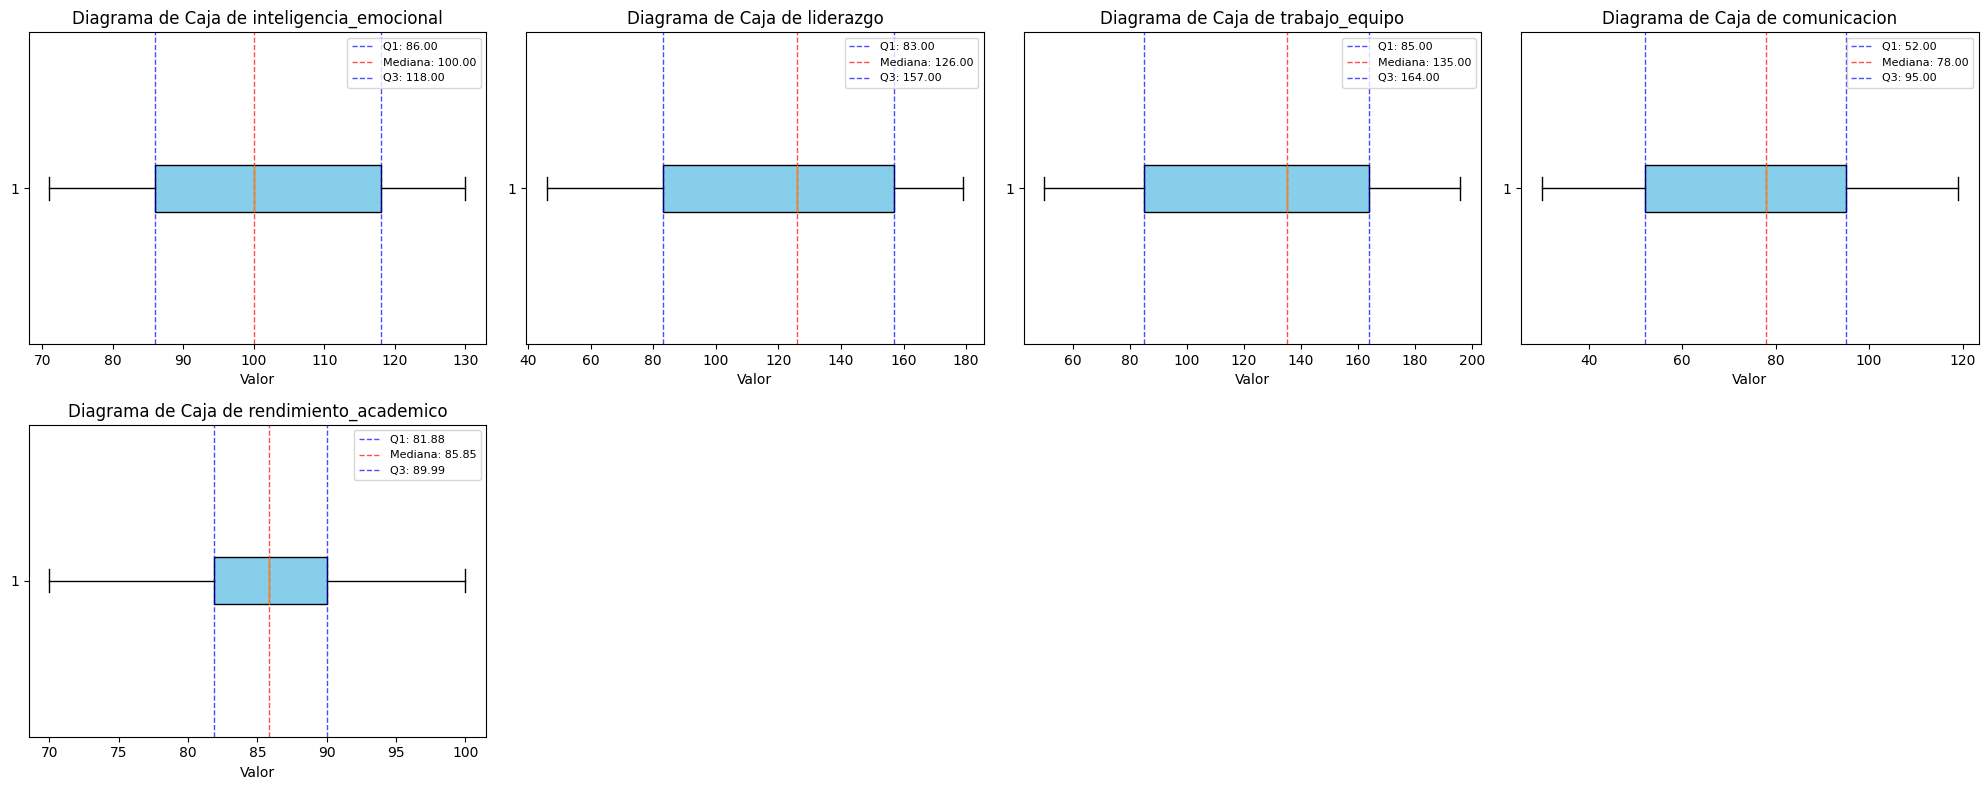

In [67]:
variables_numericas = datos_cargados.select_dtypes(include=['number']).columns.tolist()

datos_cargados[variables_numericas].describe()
f_diagrama_caja_matriz(datos_cargados[variables_numericas])

### Histogramas

Los datos de las variables independientes no tienen un comportamiento normal; algunos modelos en los supuestos, solicitan normalidad en los datos, otros modelos no son tan rigurosos. Solo la variable dependiente presenta cierta curva de campana posiblemente cercana a normalidad.

Se dejan los datos como están.


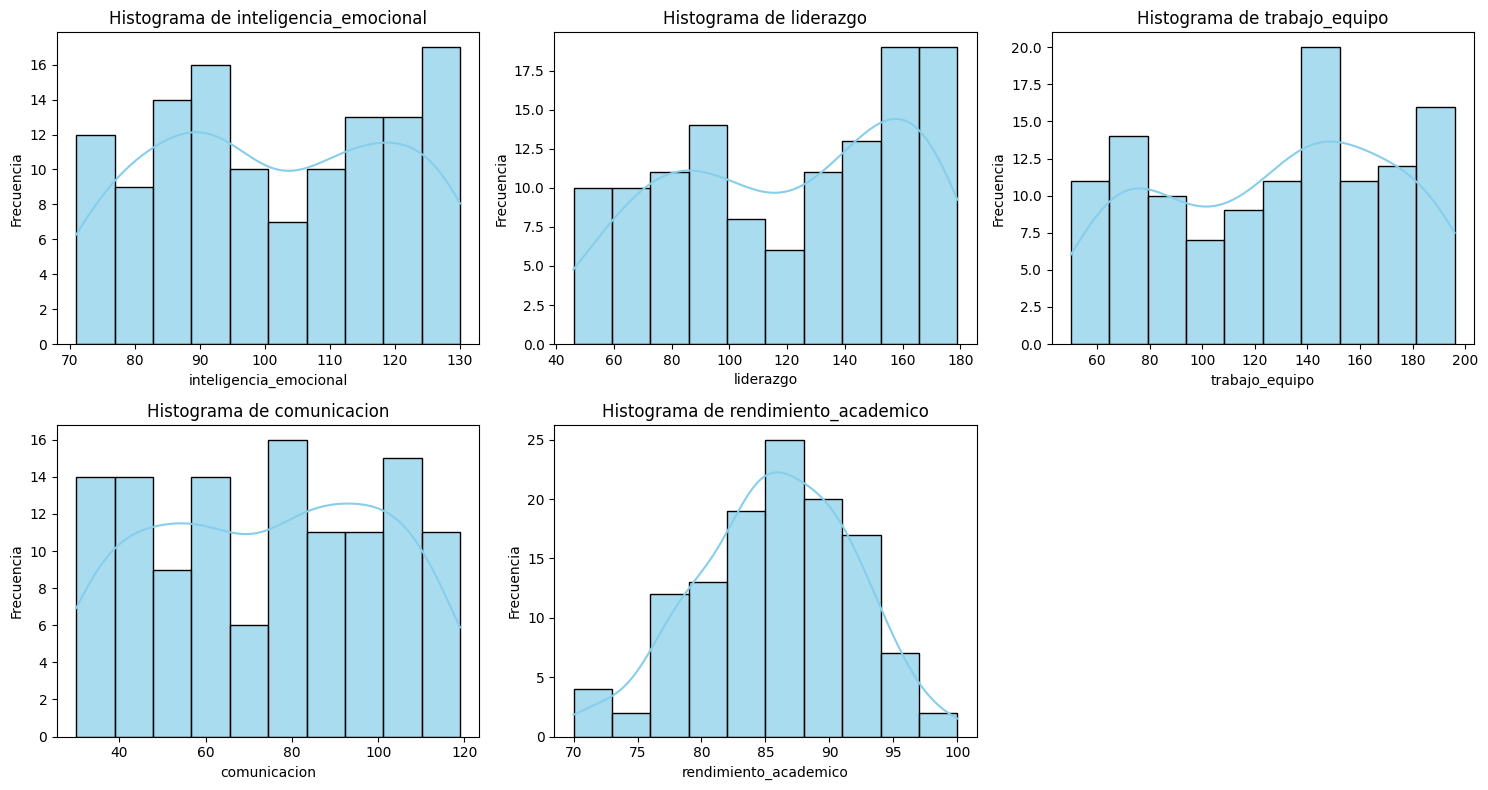

In [68]:
f_histograma_multiple_matriz_densidad(datos_cargados)

### Pruebas de normalidad en las variables

#### Prueba de Kolmovorov

* $H_0$ Los datos SI son normales; $\text{p_value} \ge 0.05$
* $H_a$ Los datos NO son normales; $\text{p_value} < 0.05$

Un p-value mayor o igual a  0.05  no se rechaza  H0  de que los datos siguen una distribución normal; por el contrario si son menores a 0.05 los datos no siguen una distribución normal. Los datos no son normnales tanto las variables independientes como la variable dependiente.

In [69]:

f_prueba_kolmovorov(datos_cargados)

                        Kolmogorov-Smirnov Statistic  p-value
inteligencia_emocional                           1.0      0.0
liderazgo                                        1.0      0.0
trabajo_equipo                                   1.0      0.0
comunicacion                                     1.0      0.0
rendimiento_academico                            1.0      0.0


#### Prueba de Shapiro

Evaluar el *p-value*:
* $p > 0.05$ → No se rechaza la normalidad (los datos podrían ser normales).

* $p ≤ 0.05$ → Se rechaza la normalidad (los datos NO siguen una distribución normal)

Se constata que los datos de variables independients no siguen una ditribución normal, pero es posible que la variable dependiente *Rendimiento_Academico* si se acerque a ser distribución normal.

In [70]:
f_prueba_shapiro(datos_cargados)

                        Shapiro-Wilk Statistic   p-value
inteligencia_emocional                0.940464  0.000043
liderazgo                             0.930782  0.000010
trabajo_equipo                        0.943112  0.000065
comunicacion                          0.947183  0.000126
rendimiento_academico                 0.991749  0.691909


### Anderson Darling

* $H_0$ Los datos SI son normales; if $\text{estadístico} \ge \text{valor_critico}$ se rechaza $H_0$
* $H_a$ Los datos NO son normales; if $\text{estadístico} < \text{valor_critico}$ se acepta $H_0$

Si el estadístico de *Anderson-Darling* es mayor o igual que el valor crítico para un nivel de significancia dado, se rechaza la hipótesis de normalidad a ese nivel.

Si el estadístico es menor, los datos podrían seguir una distribución normal.

Para las variables independientes todos los estadísticos son mayores que cualquier valor crítico, por lo que se confirma los datos no son siguen un comportamiento normal.

La variable dependiente pasa la prueba de normalidad de *Anderson-Darling* si se presume que se comporta bajo una distribución  normal.

In [71]:
f_Anderson_Darling(datos_cargados)

                        Anderson-Darling Statistic  Critical Values (15%)  \
inteligencia_emocional                    1.899214                  0.558   
liderazgo                                 2.537059                  0.558   
trabajo_equipo                            1.867050                  0.558   
comunicacion                              1.698862                  0.558   
rendimiento_academico                     0.283897                  0.558   

                        Critical Values (10%)  Critical Values (5%)  \
inteligencia_emocional                  0.636                 0.763   
liderazgo                               0.636                 0.763   
trabajo_equipo                          0.636                 0.763   
comunicacion                            0.636                 0.763   
rendimiento_academico                   0.636                 0.763   

                        Critical Values (2.5%)  Critical Values (1%)  
inteligencia_emocional                 

#### qq-plot

Visualmente se confirma que los datos no siguen un comportamiento normal excepto la variable rendimiento académico.

Todas las pruebas confirman que ninguna de las variables numéricas independientes son  normales; la variable dependiente si sigue un comportamiento mnormal.


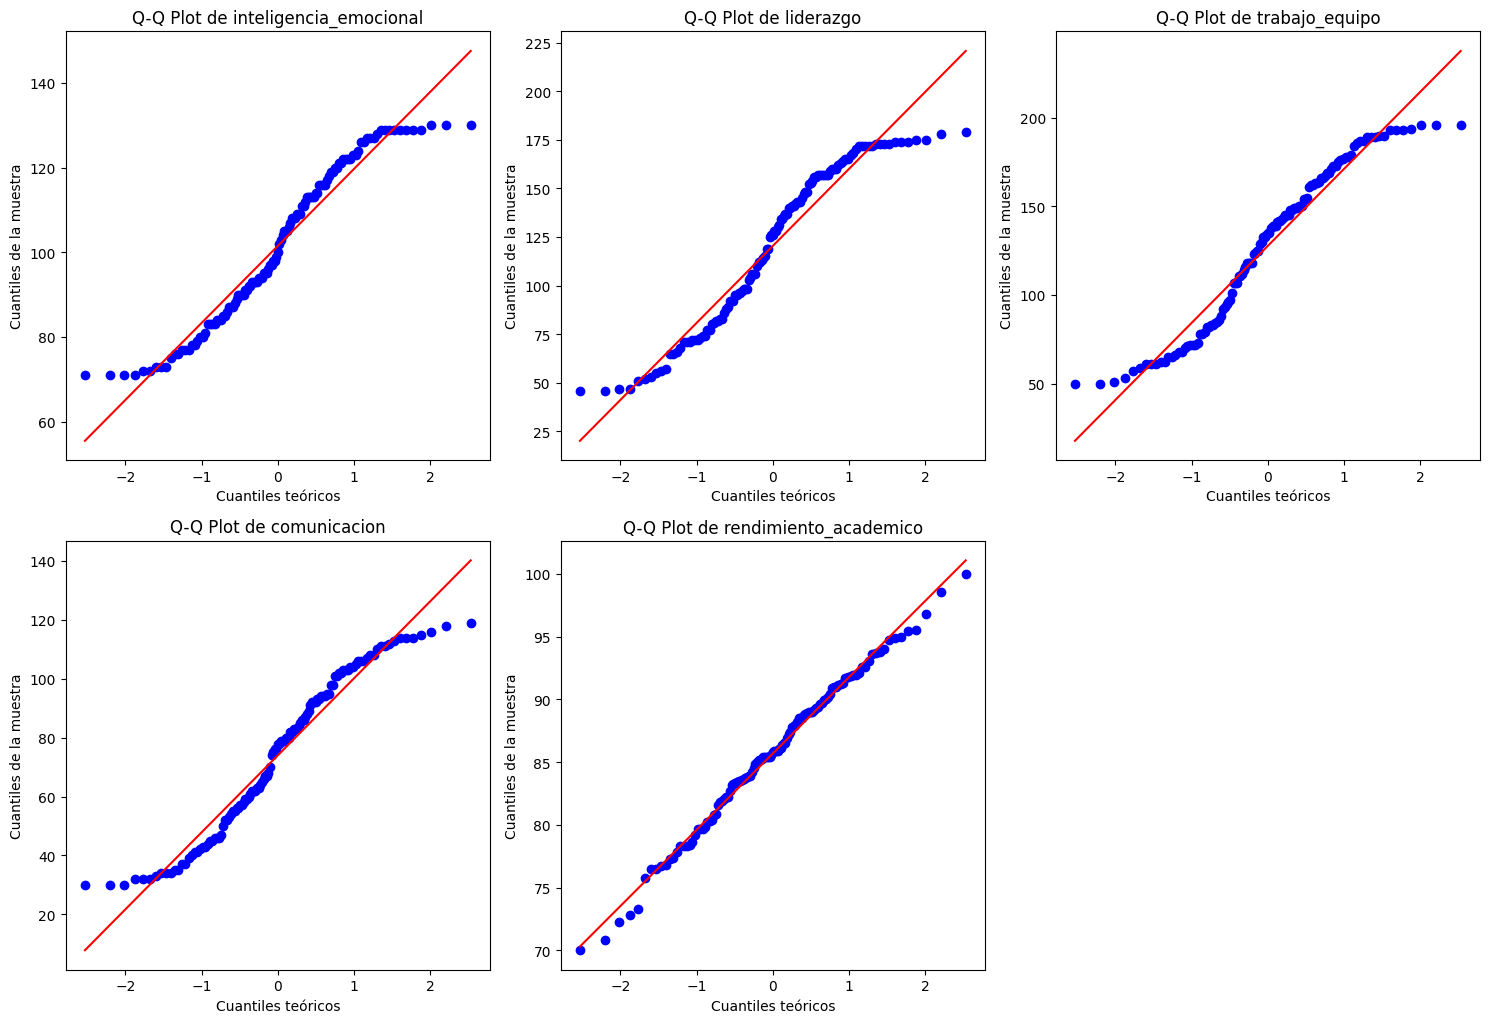

In [72]:
f_matriz_qqplots(datos_cargados)

### Correlación de variables

Se utiliza las correlaciones de *Spearman* dado que los datos no son normales.

Se observa que no hay linealidad entre las variables independientes, es decir no hay multicolinealidad.  No existe mucha relación lineal entre las variables independientes y la variable dependiente.


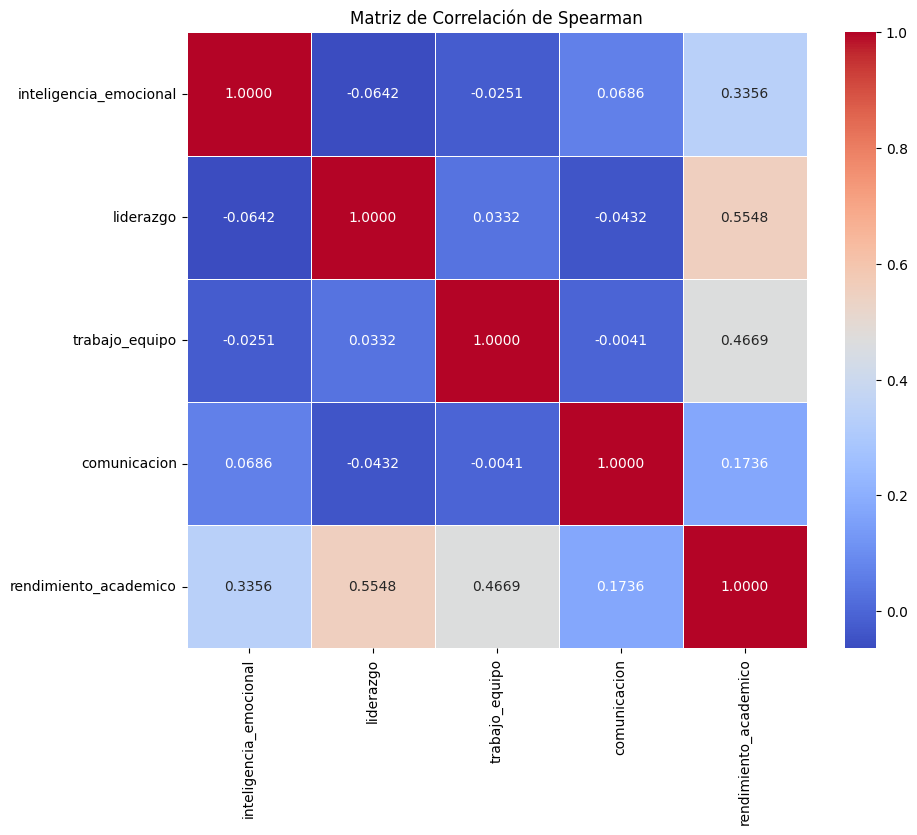

,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
inteligencia_emocional,1.0000,-0.0642,-0.0251,0.0686,0.3356
liderazgo,-0.0642,1.0000,0.0332,-0.0432,0.5548
trabajo_equipo,-0.0251,0.0332,1.0000,-0.0041,0.4669
comunicacion,0.0686,-0.0432,-0.0041,1.0000,0.1736
rendimiento_academico,0.3356,0.5548,0.4669,0.1736,1.0000


In [73]:
f_correlaciones_Spearman(datos_cargados)

### Diagramas de dispersión

Se presenta la relación entre variables independientes *"EQ_i_2.0", "MLQ", "TeamSTEPPS", "CAS"* y la variable dependiente *Rendimiento_Academico*.

Se observa que no hay importante relación linealmente hablando entre las variables variables independientes *"EQ_i_2.0", "MLQ", "TeamSTEPPS", "CAS"* y la variable dependiente *Rendimiento_Academico* por lo que probablemente en algunos modelos habrá que escalar datos.


Index(['inteligencia_emocional', 'liderazgo', 'trabajo_equipo',
       'comunicacion'],
      dtype='object')


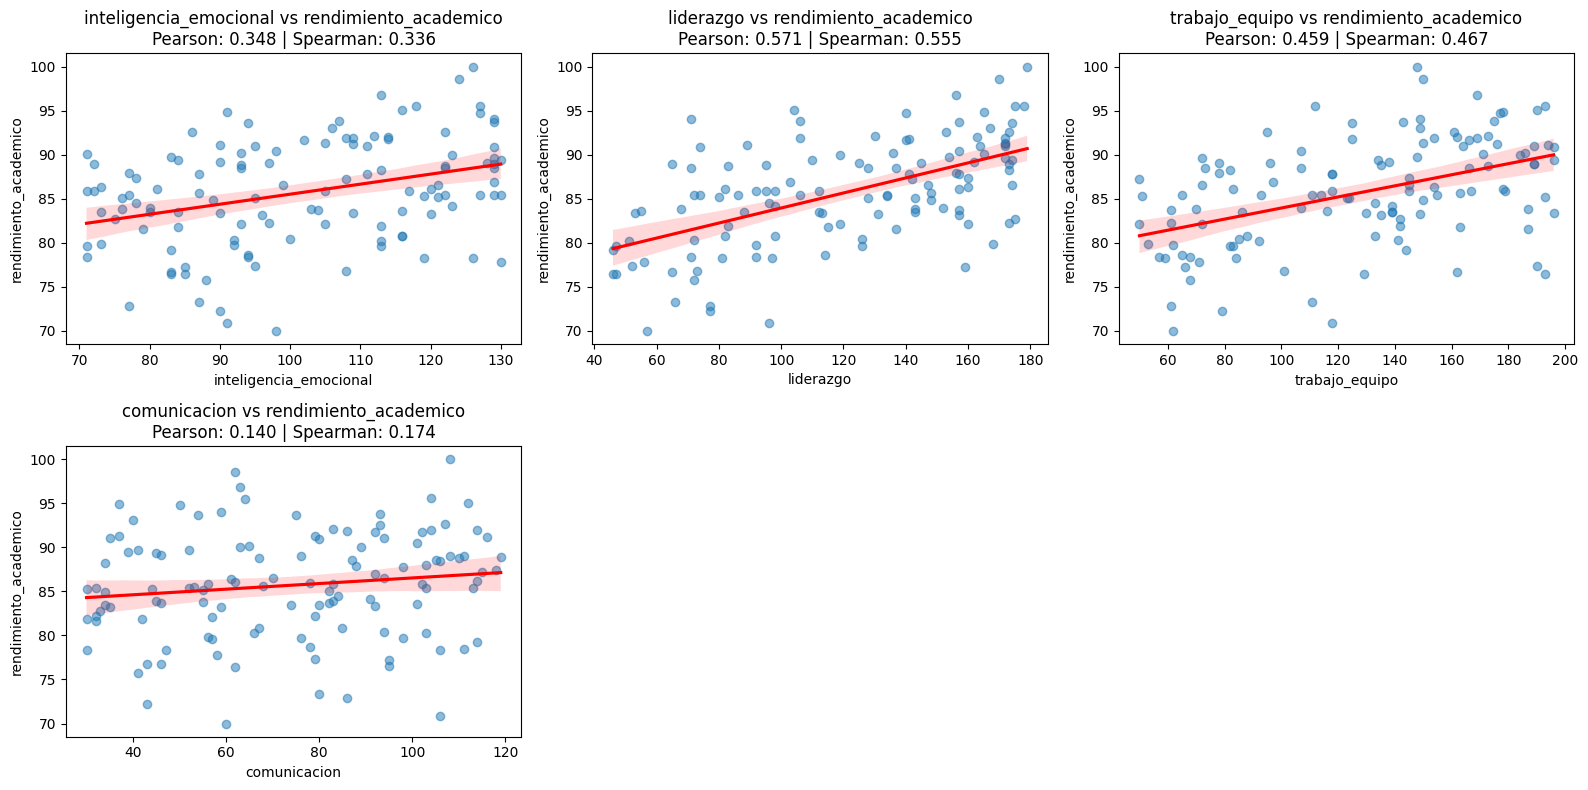

In [74]:
# Supongamos que la variable dependiente se llama "rendimiento_academico"
dependiente = "rendimiento_academico"

# Extraer los nombres de las variables independientes
independientes = datos_cargados.columns.drop(dependiente)

print (independientes)
# Uso de la función con los datos cargados
f_dispersion_matriz(datos_cargados, independientes, dependiente)


## Transformar datos

### Escalar datos

Dado que se observa que no hay una relación lineal entre variables independientes y la variable dependiente, se van a escalar los datos.


In [75]:
# Escalar
# Crear una copia del DataFrame para no modificar el original
datos_escalados = datos_cargados.copy()

variables_numericas_independientes = datos_escalados.columns[:-1]  # Excluye la última columna (variable dependiente)
# todos en un ciclo for
for variable in variables_numericas_independientes:
    datos_escalados[variable] = f_escalar(datos_escalados, variable)
datos_escalados.head(10)

,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
0,0.6271,0.2030,0.3493,0.1461,76.79
1,0.8475,0.2556,0.9795,0.1573,85.21
2,0.4576,0.0827,0.0822,0.3371,70.00
3,0.2203,0.5188,0.7740,0.0000,81.85
4,0.6949,0.6316,0.8425,0.5955,92.08
5,0.1017,0.1955,0.7192,0.0225,85.40
6,1.0000,0.4812,1.0000,0.1685,89.36
7,0.3220,0.3233,0.9863,0.9663,91.13
8,0.6271,0.4511,0.8151,0.6292,91.89
9,0.9492,0.9925,0.4247,0.8315,95.54


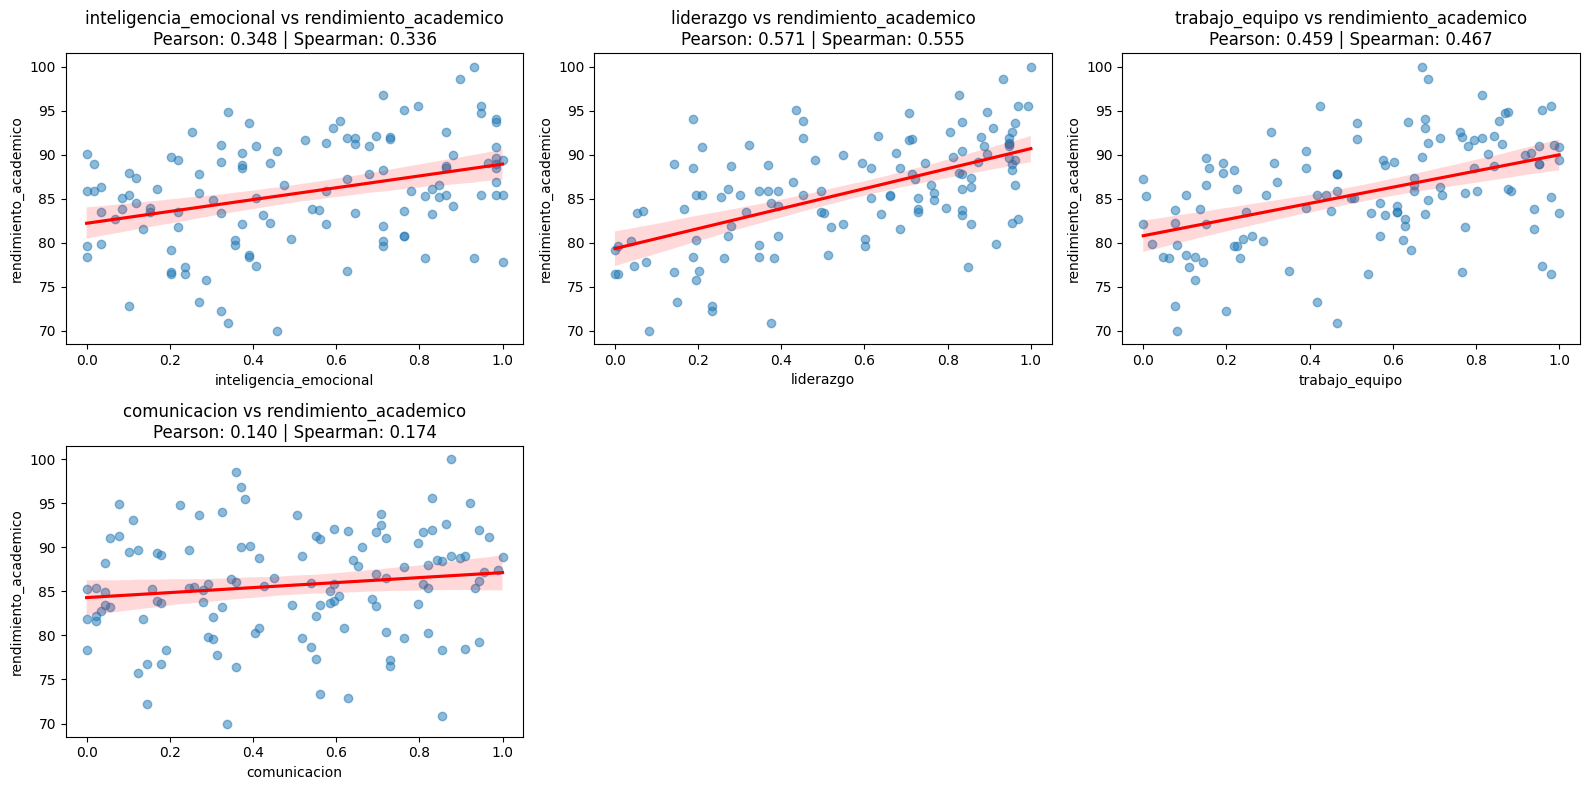

In [76]:
# Uso de la función con los datos cargados
f_dispersion_matriz(datos_escalados, independientes, dependiente)


## Datos de entrenamiento y datos de validación datos originales

Se hace la partición de datos con datos originalmennte cargados.

* datos = datos_cargados,
* 80% datos de entrenamiento,
* 20% datos de validación,
* *X_train* son las variables independientes de entrenamiento,
* *X_test* son las variables independientes de validación,
* *y_train* es la variable dependiente de entrenamiento,
* *y_test* es la variable dependiente de validación,
* Semilla 2025 --> *random_state=2025*

In [77]:
# Separar características (X) y variable objetivo (y)
X = datos_cargados.drop("rendimiento_academico", axis=1)  # Características variables independientes]
y = datos_cargados["rendimiento_academico"]  # Variable objetivo dependiente

# Dividir los datos en entrenamiento (80%) y validación (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)



In [78]:
print ("Primeros registros datos de entrenamiento")
# Combinar X_train y y_train en un solo DataFrame
datos_entrenamiento = pd.concat([X_train, y_train], axis=1)
datos_entrenamiento.head(10)

Primeros registros datos de entrenamiento


,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
37,118,175,193,64,95.50
44,84,174,134,39,89.44
14,93,128,166,105,88.54
109,85,159,66,95,77.24
7,90,89,194,116,91.13
46,120,131,149,59,83.26
43,85,46,193,95,76.48
65,78,96,133,84,84.51
1,121,80,193,44,85.21
88,111,164,164,94,91.02


In [79]:

print ("Primeros registros datos de validación")
# Combinar X_train y y_train en un solo DataFrame
datos_validacion = pd.concat([X_test, y_test], axis=1)
datos_validacion.head(10)

Primeros registros datos de validación


,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
118,129,65,189,108,88.97
2,98,57,62,60,70.00
47,113,173,82,34,88.24
81,105,92,179,102,85.88
63,119,134,51,30,85.28
116,94,71,68,111,78.43
91,98,157,107,101,90.44
19,72,173,189,119,88.90
48,124,170,150,62,98.60
68,71,126,82,98,79.67


## Datos de entrenamiento y datos de validación datos escalados

Se hace la partición de datos con datos originalmennte escalados.

In [80]:
# Separar características (X) y variable objetivo (y)
X = datos_escalados.drop("rendimiento_academico", axis=1)  # Características variables independientes]
y = datos_escalados["rendimiento_academico"]  # Variable objetivo dependiente

# Dividir los datos en entrenamiento (80%) y validación (20%)
X_train_escala, X_test_escala, y_train_escala, y_test_escala = train_test_split(X, y, test_size=0.2, random_state=2025)


In [81]:
print ("Primeros registros datos de entrenamiento")
# Combinar X_train y y_train en un solo DataFrame
datos_entrenamiento_escala = pd.concat([X_train_escala, y_train_escala], axis=1)
datos_entrenamiento_escala.head(10)

Primeros registros datos de entrenamiento


,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
37,0.7966,0.9699,0.9795,0.3820,95.50
44,0.2203,0.9624,0.5753,0.1011,89.44
14,0.3729,0.6165,0.7945,0.8427,88.54
109,0.2373,0.8496,0.1096,0.7303,77.24
7,0.3220,0.3233,0.9863,0.9663,91.13
46,0.8305,0.6391,0.6781,0.3258,83.26
43,0.2373,0.0000,0.9795,0.7303,76.48
65,0.1186,0.3759,0.5685,0.6067,84.51
1,0.8475,0.2556,0.9795,0.1573,85.21
88,0.6780,0.8872,0.7808,0.7191,91.02


In [82]:
print ("Primeros registros datos de validación")
# Combinar X_train y y_train en un solo DataFrame
datos_validacion_escala = pd.concat([X_test_escala, y_test_escala], axis=1)
datos_validacion_escala.head(10)

Primeros registros datos de validación


,inteligencia_emocional,liderazgo,trabajo_equipo,comunicacion,rendimiento_academico
118,0.9831,0.1429,0.9521,0.8764,88.97
2,0.4576,0.0827,0.0822,0.3371,70.00
47,0.7119,0.9549,0.2192,0.0449,88.24
81,0.5763,0.3459,0.8836,0.8090,85.88
63,0.8136,0.6617,0.0068,0.0000,85.28
116,0.3898,0.1880,0.1233,0.9101,78.43
91,0.4576,0.8346,0.3904,0.7978,90.44
19,0.0169,0.9549,0.9521,1.0000,88.90
48,0.8983,0.9323,0.6849,0.3596,98.60
68,0.0000,0.6015,0.2192,0.7640,79.67


## Regresión múltiple

* Con datos originales

In [83]:
# Crear un diccionario para almacenar los resultados.
# Variable global, se puede acceder con las funciones datos que es un diccionario
resultados = {}

# Para almacenar los gráficos de diferencias entre prediciones y valores reales
gr_diferencias_predicciones = {}  # Diccionario global para almacenar los gráficos




=== Regresión Lineal Múltiple. Datos originales ===
MSE: 12.8859
RMSE: 3.5897
R²: 0.6806
R² Ajustado: 0.6167

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}}


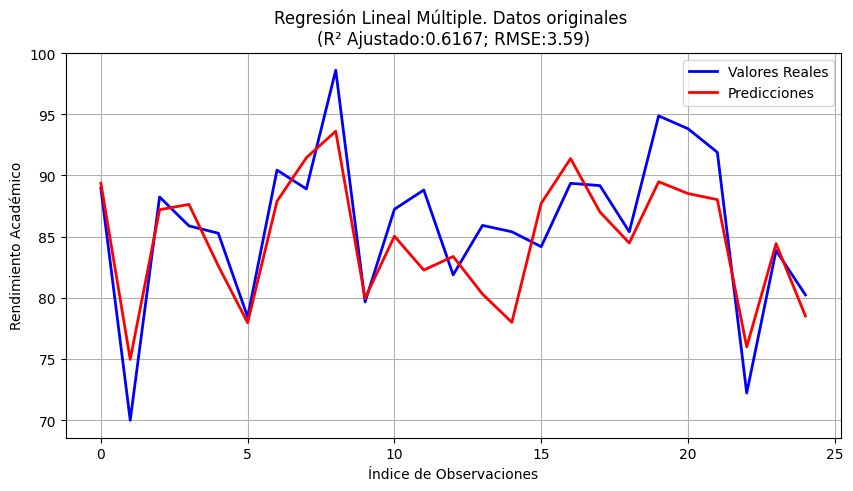

In [84]:
# Entrenar y evaluar el modelo de Regresión Múltiple
nombre_modelo = "Regresión Lineal Múltiple. Datos originales"
rm_modelo = LinearRegression()
rm_modelo.fit(X_train, y_train)
f_evaluar_modelo(rm_modelo, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

* Con datos esacalados



=== Regresión Lineal Múltiple. Datos escalados ===
MSE: 12.8862
RMSE: 3.5897
R²: 0.6805
R² Ajustado: 0.6167

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}}


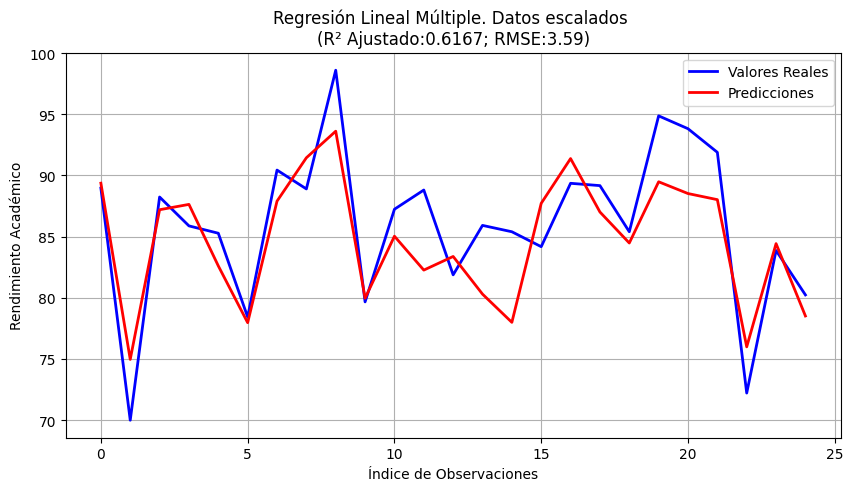

In [85]:
# Entrenar y evaluar el modelo de Regresión Múltiple
nombre_modelo = "Regresión Lineal Múltiple. Datos escalados"
rm_modelo_escala = LinearRegression()
rm_modelo_escala.fit(X_train_escala, y_train_escala)
f_evaluar_modelo(rm_modelo_escala, X_test_escala, y_test_escala, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

Al utilizar los datos originales y con los datpos escalados con el modelo de regresión múltiple se obtuvieron los mismos resultados que hacen pensar que el modelo no funciona adecuadamente, sin embargo, falta aplicar la técnica de validación: **'MSE': 12.88, 'RMSE': 3.58, 'R²': 0.68, 'R² Ajustado': 0.61** por lo que se confirmna que el modelo explica alrededor del *61%*.


En los modelos de regresión lineal múltiple los resultados de la evaluación salieron igual con datos originales y con datos escalados, esto implica que el escalamiento no afectó a los resultados de la evaluación.

Cuando se aplica un modelo de regresión múltiple y no se están aplicando técnicas de regularización, el escalamiento de los datos no debería de afectar los resultados del modelo.

Cuando se escalan las variables predictoras, los coeficientes de regresión cambian, pero la relación lineal entre las variables predictoras y la variable objetivo permanece igual. Esto significa que las predicciones del modelo y, por lo tanto, los estadísticos de evaluación, no cambian.

Cuando se aplica un modelo de regresión múltiple y no se están aplicando técnicas de regularización, el escalamiento de los datos no debería de afectar los resultados del modelo. (Gemini, 2025).

Las técnicas como la regularización L1 (*Lasso*) y L2 (*Ridge*) penalizan los coeficientes grandes. El escalamiento es esencial con regularización para evitar que variables con escalas mayores dominen el proceso de penalización. **hay que escalar con regulación... pendiente...**

## Regresión lineal múltiple con técnica regulación Lasso

*Lasso* es una técnica de regularización utilizada en modelos de regresión lineal. Su objetivo principal es mejorar la precisión y la interpretabilidad de los modelos al penalizar la magnitud de los coeficientes.

A diferencia de la regresión lineal ordinaria, *Lasso* puede reducir algunos coeficientes a cero, lo que esencialmente realiza la selección de variables. Gemini. (2025).

Las estrategias de regularización incorporan penalizaciones en el ajuste por mínimos cuadrados ordinarios (*OLS*) con el objetivo de evitar *overfitting*, reducir varianza, atenuar el efecto de la correlación entre predictores y minimizar la influencia en el modelo de los predictores menos relevantes.

Por lo general, aplicando regularización se consigue modelos con mayor poder predictivo (generalización).
https://cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

$$
\min_{\beta} \left\{ \frac{1}{2n} \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} x_{ij} \beta_j)^2 + \alpha \sum_{j=1}^{p} |\beta_j| \right\}
$$

Donde:

* β: Vector de coeficientes de regresión.
* β₀: Intercepto.
* βⱼ: Coeficiente para la j-ésima variable predictora.
* xᵢⱼ: Valor de la j-ésima variable predictora para la i-ésima observación.
* yᵢ: Valor de la variable de respuesta para la i-ésima observación.
* n: Número de observaciones.
* p: Número de variables predictoras.
* α: Parámetro de regularización (lambda).

Para los datos de prediciones de rendimiento académico y las variables independienrtes la fórmula usando *Lasso* quedaría de la siguiente manera:
* $x_1$ inteligencia_emocional
* $x_2$ liderazgo
* $x_3$ trabajo_equipo
* $x_4$ comunicacion

$$
\min_{\beta} \left\{ \frac{1}{2n} \sum_{i=1}^{n} \left( y_i - \beta_0 - \beta_1 \cdot \text{x1}_i - \beta_2 \cdot \text{x2}_i - \beta_3 \cdot \text{x3}_i - \beta_4 \cdot \text{x4}_i \right)^2 + \alpha \left( |\beta_1| + |\beta_2| + |\beta_3| + |\beta_4| \right) \right\}
$$

Ajuste el modelo de regresión *Lasso* en los datos de entrenamiento y elejir un valor para $α$ o $λ$ (*alfa o lambda en algunas fórmulas*) con el objetivo de minimizar el error cuadrático medio (MSE).

El error cuadrático medio (MSE) puede ayudar a determinar un valor $α$ adecuado. MSE es un medio para medir la diferencia, en promedio, entre los valores previstos y verdaderos de la variable dependiente.

La regresión Lasso minimiza el error cuadrático medio (MSE) mientras equilibra los factores opuestos de sesgo y varianza para construir el modelo predictivo más preciso. Esto se logra agregando un término de penalización a la suma residual de cuadrados (RSS) igual a la suma de los valores absolutos de los coeficientes multiplicados por un parámetro $α$. https://www.ibm.com/mx-es/think/topics/lasso-regression

Finalmente, *Lasso* es útil para seleccionar características, mientras que *Ridge* es útil para reducir la magnitud de los coeficientes.


=== Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1)  ===
MSE: 12.8710
RMSE: 3.5876
R²: 0.6809
R² Ajustado: 0.6171


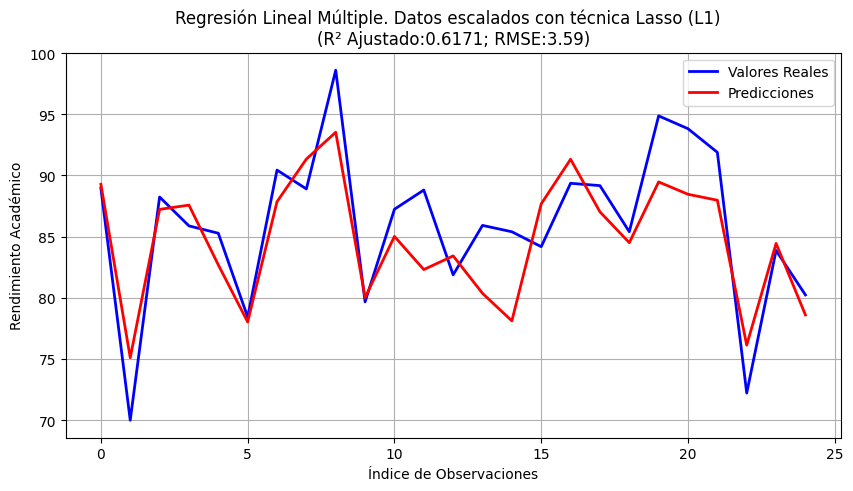

In [86]:
# Entrenar y evaluar un modelo Lasso (regularización L1)
nombre_modelo = "Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) "
modelo_lasso = Lasso(alpha=0.01)  # alpha es el parámetro de regularización


modelo_lasso.fit(X_train_escala, y_train_escala)

f_evaluar_modelo(modelo_lasso, X_test_escala, y_test_escala, nombre_modelo)


## Regresión lineal múltiple con técnica regulación Ridge

Similar a Lasso pero ahora optimizando con la técnica de regulación llamada *Ridge*.

Cuando se trabaja con la técnica de *Ridge Regression*, es crucial escalar tus datos.

*Ridge* es un tipo de regresión regularizada, que añade una penalización a la función de pérdida para evitar el sobreajuste. Esta penalización está directamente influenciada por la magnitud de los coeficientes de las variables predictoras.

Por lo tanto, si las variables predictoras tienen escalas muy diferentes, aquellas con escalas más grandes pueden dominar el proceso de regularización, lo que lleva a resultados subóptimos.

$$
J(w) = RSS(w) + \alpha ||w||_2^2
$$

Donde:

* $(J(w))$ es la función de costo que se desea minimizar.
* $(RSS(w))$ es la suma de los cuadrados de los residuos (Residual Sum of Squares).
* $(\alpha)$ es el parámetro de regularización (alpha).
* $(||w||_2^2)$ es la norma L2 al cuadrado de los coeficientes (w).

*Ridge Regression* utiliza la regularización *L2* para reducir la complejidad del modelo y mejorar su capacidad de generalización.

La fórmula de *Ridge* añade un término de penalización *L2* a la función de costo de mínimos cuadrados lineales.




=== Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2)  ===
MSE: 13.3390
RMSE: 3.6523
R²: 0.6693
R² Ajustado: 0.6032


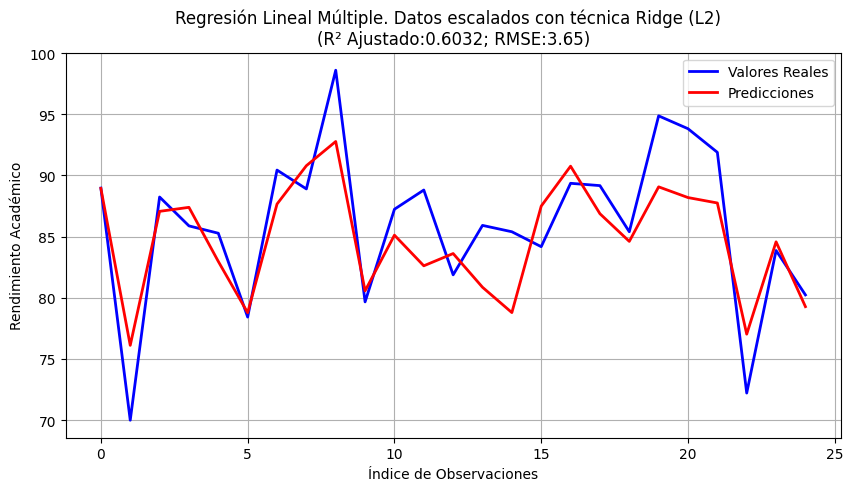

In [87]:
nombre_modelo = "Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) "

# Entrenar el modelo Ridge


modelo_ridge = Ridge(alpha=1.0)  # alpha es el parámetro de regularización
modelo_ridge.fit(X_train_escala, y_train_escala)

f_evaluar_modelo(modelo_ridge, X_test_escala, y_test_escala, nombre_modelo)



## Regresión polinomial




=== Modelo Polinomial segundo grado. Datos Originales ===
MSE: 15.8565
RMSE: 3.9820
R²: 0.6069
R² Ajustado: 0.5283

=== Modelo Polinomial tercer grado. Datos Originales ===
MSE: 27.4025
RMSE: 5.2347
R²: 0.3207
R² Ajustado: 0.1848

=== Modelo Polinomial cuarto grado. Datos Originales ===
MSE: 92.5001
RMSE: 9.6177
R²: -1.2931
R² Ajustado: -1.7517

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.6522

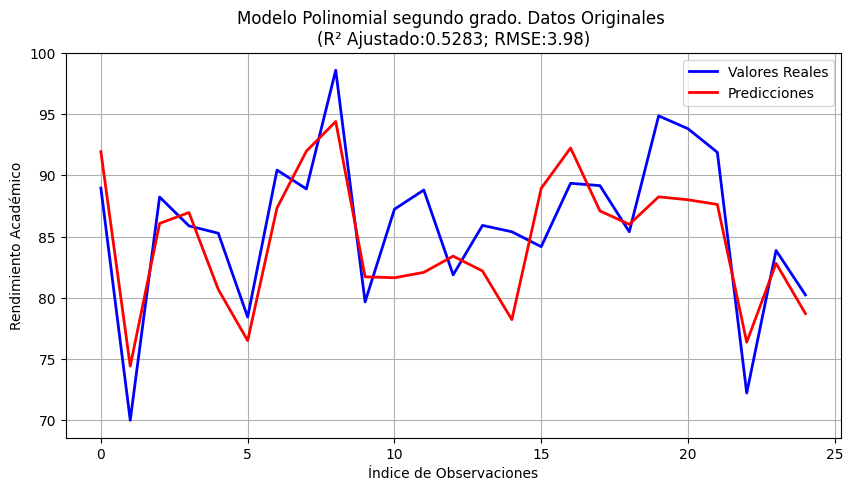

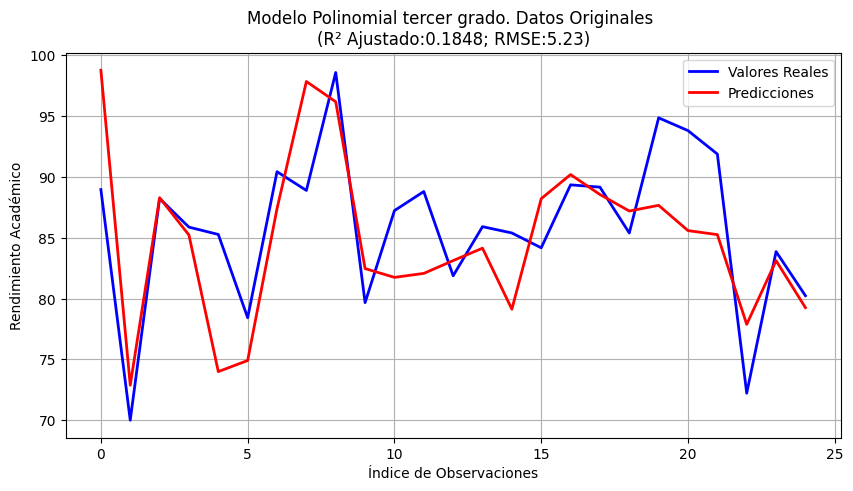

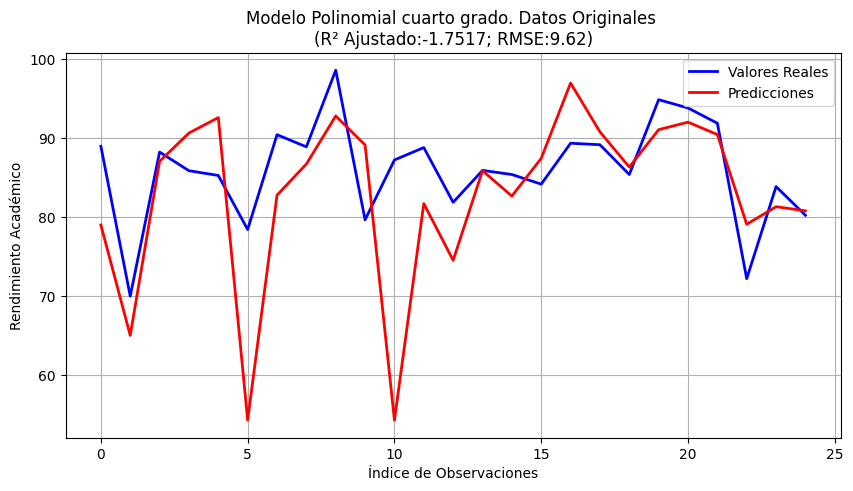

In [88]:
# Entrenar y evaluar el modelo de Árbol de Regresión
nombre_modelo = "Modelo Polinomial segundo grado. Datos Originales"
f_evaluar_modelo_polinomial(2, X_train, X_test, y_train, y_test, nombre_modelo)

nombre_modelo = "Modelo Polinomial tercer grado. Datos Originales"
f_evaluar_modelo_polinomial(3, X_train, X_test, y_train, y_test, nombre_modelo)

nombre_modelo = "Modelo Polinomial cuarto grado. Datos Originales"
f_evaluar_modelo_polinomial(4, X_train, X_test, y_train, y_test, nombre_modelo)


# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

De los modelos polinomiales de regresión, el de segundo grado es el que tiene mejor rendimiento **MSE: 15.8565, RMSE: 3.9820, R²: 0.6069, R² Ajustado: 0.5283**; aproximadamente las variables indepéndientes explican alrededor del *52%* la variabilidad del rendimiento académico.



## Arbol de regresión




=== Arbol de Regresión. Datos originales ===
MSE: 19.8184
RMSE: 4.4518
R²: 0.5087
R² Ajustado: 0.4104

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustado': 0.528299914237637}, 

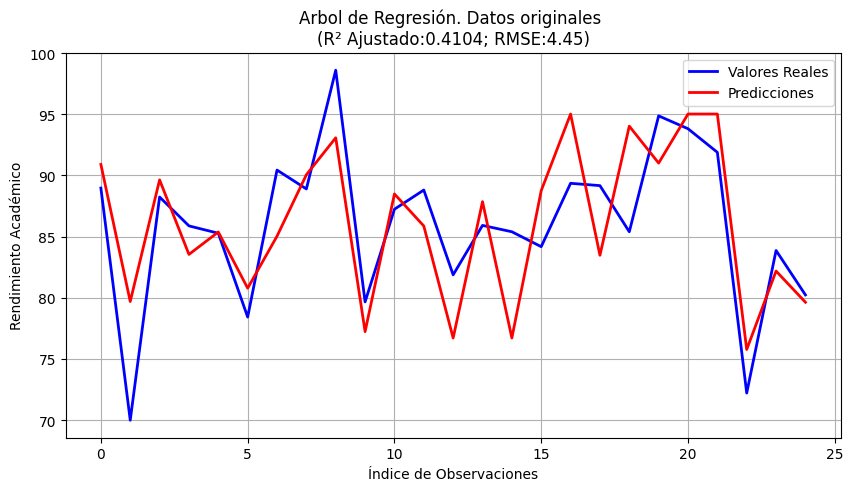

In [89]:
# Entrenar y evaluar el modelo de Árbol de Regresión
nombre_modelo = "Arbol de Regresión. Datos originales"
modelo_ar = DecisionTreeRegressor(max_depth=None, random_state=2025)
modelo_ar.fit(X_train, y_train)

f_evaluar_modelo(modelo_ar, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

Los estadísticos del modelo de árboles de regrsión son **MSE: 19.8184, RMSE: 4.4518, R²: 0.5087, R² Ajustado: 0.4104**;  con los dagtos originales este modelo explica aproximadamente el *41%* la variabilidad de la variable dependiente rendimiento académico.

## Randon Forest




=== Random Forest. Datos originales ===
MSE: 11.7295
RMSE: 3.4248
R²: 0.7092
R² Ajustado: 0.6511

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustado': 0.528299914237637}, 'Mode

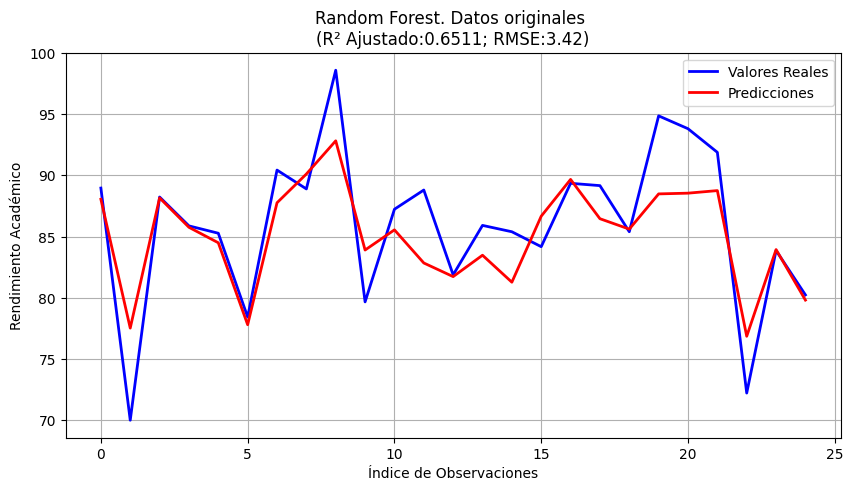

In [90]:
# Entrenar y evaluar el modelo Random Forest
nombre_modelo = "Random Forest. Datos originales"
modelo_rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=2025)
modelo_rf.fit(X_train, y_train)

f_evaluar_modelo(modelo_rf, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)


Los estadísticos de evaluación del modelo de *Random Forest* son **SE: 12.88, RMSE: 3.58, R²: 0.68, R² Ajustado: 0.65**;  con los datos originales este modelo explica aproximadamente el *65%* la variabilidad de la variable dependiente rendimiento académico.

## Gradient Boosting Regressor


=== Gradient Boosting Regressor. Datos originales ===
MSE: 16.3373
RMSE: 4.0419
R²: 0.5950
R² Ajustado: 0.5140

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustado': 0.528299914

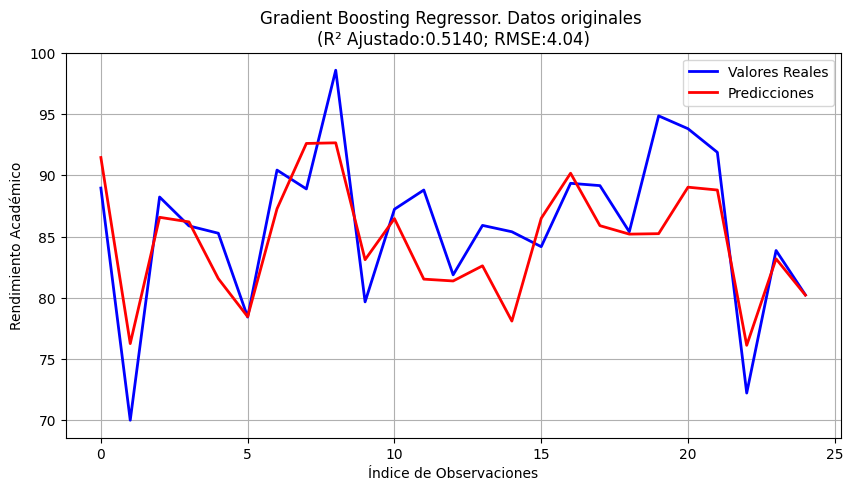

In [91]:
# Crear y entrenar el modelo Gradient Boosting
nombre_modelo = "Gradient Boosting Regressor. Datos originales"
modelo_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2025)
modelo_gb.fit(X_train, y_train)

f_evaluar_modelo(modelo_gb, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

## Máquinas de Soporte para Regresión



=== Máquinas de Soporte para Regresión. Lineal. Datos originales ===
MSE: 13.3135
RMSE: 3.6488
R²: 0.6700
R² Ajustado: 0.6039

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustad

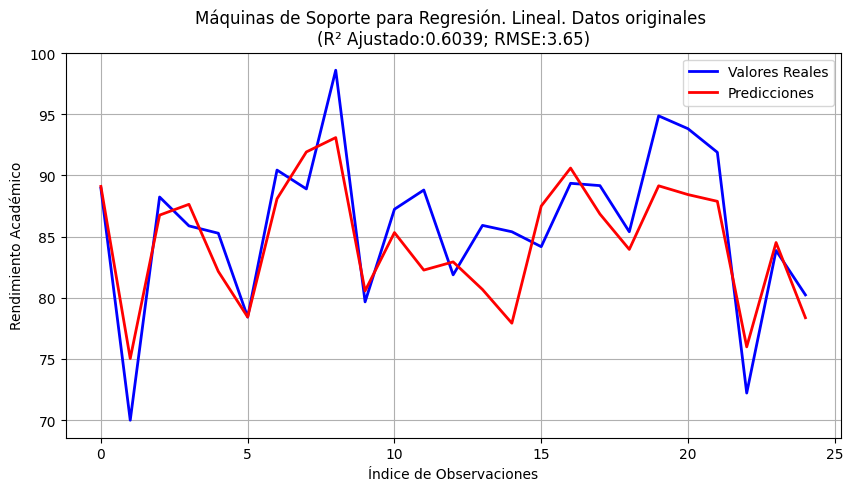

In [92]:
# Crear y entrenar el modelo SVR
nombre_modelo = "Máquinas de Soporte para Regresión. Lineal. Datos originales"

# Entrenar y evaluar el modelo SVR
modelo_svr = SVR(kernel='linear')  # Se usa un kernel lineal (RBF)
modelo_svr.fit(X_train, y_train)

f_evaluar_modelo(modelo_svr, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)


=== Máquinas de Soporte para Regresión. Radial. Datos originales ===
MSE: 16.0938
RMSE: 4.0117
R²: 0.6010
R² Ajustado: 0.5212

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustad

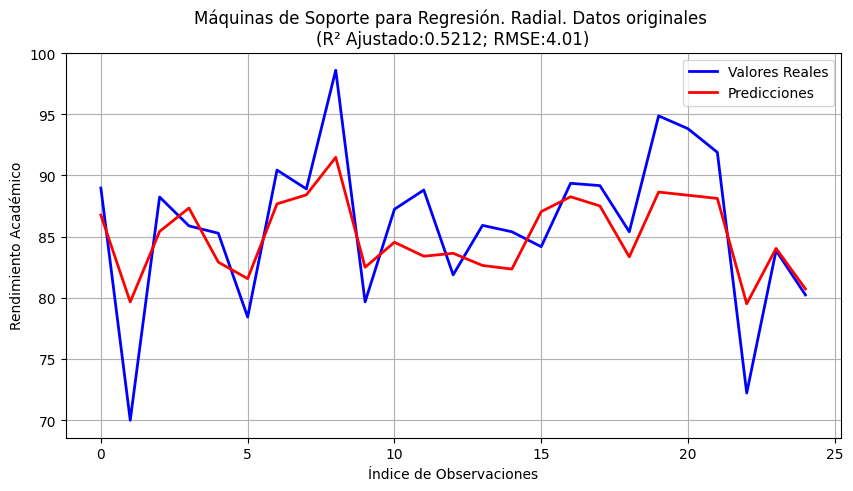

In [93]:
# Crear y entrenar el modelo SVR Radial
nombre_modelo = "Máquinas de Soporte para Regresión. Radial. Datos originales"

# Entrenar y evaluar el modelo SVR
modelo_svr = SVR(kernel='rbf')  # Se usa un kernel radial (RBF)
modelo_svr.fit(X_train, y_train)

f_evaluar_modelo(modelo_svr, X_test, y_test, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

## Máquinas de Soporte para Regresión CON DATOS ESCALADOS

Se construye el mismo modelos de máquinas de soporte para regresión pero ahora usando los datos previamente escalados




=== Máquinas de Soporte para Regresión. lineal. Datos escalados ===
MSE: 15.4141
RMSE: 3.9261
R²: 0.6179
R² Ajustado: 0.5415

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustado

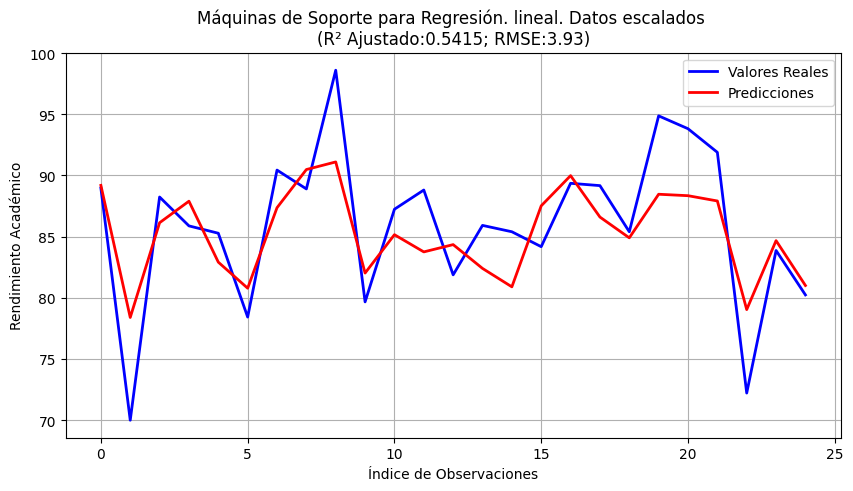

In [94]:
# Crear y entrenar el modelo Gradient Boosting
nombre_modelo = "Máquinas de Soporte para Regresión. lineal. Datos escalados"

# Entrenar y evaluar el modelo SVR
modelo_svr_escala = SVR(kernel='linear')  # Se usa un kernel lineal (lineal)
modelo_svr_escala.fit(X_train_escala, y_train_escala)

f_evaluar_modelo(modelo_svr_escala, X_test_escala, y_test_escala, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)


=== Máquinas de Soporte para Regresión. Radial. Datos escalados ===
MSE: 17.5349
RMSE: 4.1875
R²: 0.5653
R² Ajustado: 0.4784

Resultados completos:
{'Regresión Lineal Múltiple. Datos originales': {'MSE': 12.885895199378899, 'RMSE': 3.5896929115704173, 'R²': 0.6805578807684323, 'R² Ajustado': 0.6166694569221187}, 'Regresión Lineal Múltiple. Datos escalados': {'MSE': 12.886236417434798, 'RMSE': 3.5897404387274015, 'R²': 0.6805494219522453, 'R² Ajustado': 0.6166593063426944}, 'Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1) ': {'MSE': 12.871026977342266, 'RMSE': 3.5876213536746415, 'R²': 0.6809264648895275, 'R² Ajustado': 0.617111757867433}, 'Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2) ': {'MSE': 13.338998057921764, 'RMSE': 3.652259308691233, 'R²': 0.6693254335753347, 'R² Ajustado': 0.6031905202904017}, 'Modelo Polinomial segundo grado. Datos Originales': {'MSE': 15.856492472181964, 'RMSE': 3.9820211541605306, 'R²': 0.6069165951980309, 'R² Ajustado

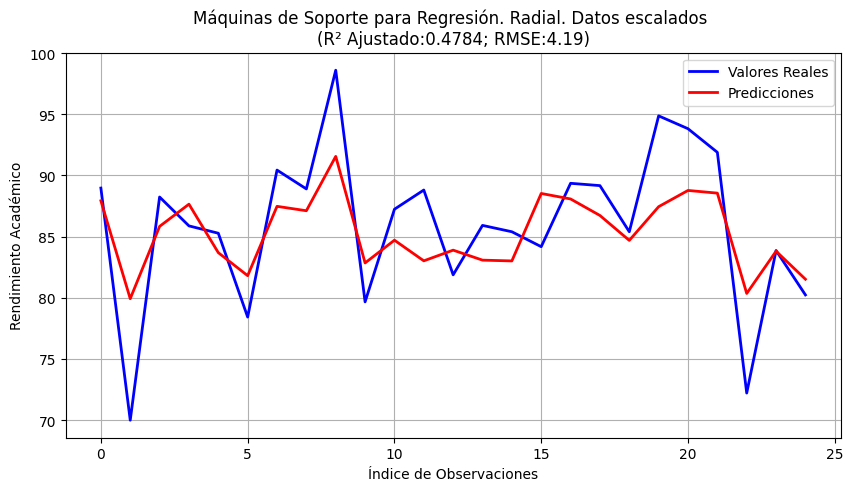

In [95]:
# Crear y entrenar el modelo Gradient Boosting
nombre_modelo = "Máquinas de Soporte para Regresión. Radial. Datos escalados"

# Entrenar y evaluar el modelo SVR
modelo_svr_escala = SVR(kernel='rbf')  # Se usa un kernel radial ()
modelo_svr_escala.fit(X_train_escala, y_train_escala)

f_evaluar_modelo(modelo_svr_escala, X_test_escala, y_test_escala, nombre_modelo)

# Mostrar el diccionario de resultados
print("\nResultados completos:")
print(resultados)

## Tabla resumen comparativo

In [96]:
# Crear el DataFrame a partir del diccionario
tabla = pd.DataFrame(resultados)

# Transponer el DataFrame
tabla = tabla.T

# Imprimir el DataFrame
tabla

,MSE,RMSE,R²,R² Ajustado
Regresión Lineal Múltiple. Datos originales,12.885895,3.589693,0.680558,0.616669
Regresión Lineal Múltiple. Datos escalados,12.886236,3.589740,0.680549,0.616659
Regresión Lineal Múltiple. Datos escalados con técnica Lasso (L1),12.871027,3.587621,0.680926,0.617112
Regresión Lineal Múltiple. Datos escalados con técnica Ridge (L2),13.338998,3.652259,0.669325,0.603191
Modelo Polinomial segundo grado. Datos Originales,15.856492,3.982021,0.606917,0.528300
Modelo Polinomial tercer grado. Datos Originales,27.402496,5.234739,0.320690,0.184829
Modelo Polinomial cuarto grado. Datos Originales,92.500063,9.617695,-1.293082,-1.751699
Arbol de Regresión. Datos originales,19.818380,4.451784,0.508701,0.410441
Random Forest. Datos originales,11.729471,3.424831,0.709226,0.651071
Gradient Boosting Regressor. Datos originales,16.337297,4.041942,0.594997,0.513997


## Diferencias de predicciones

Diferencia de las predicciones y los valores reales de todos los modelos.

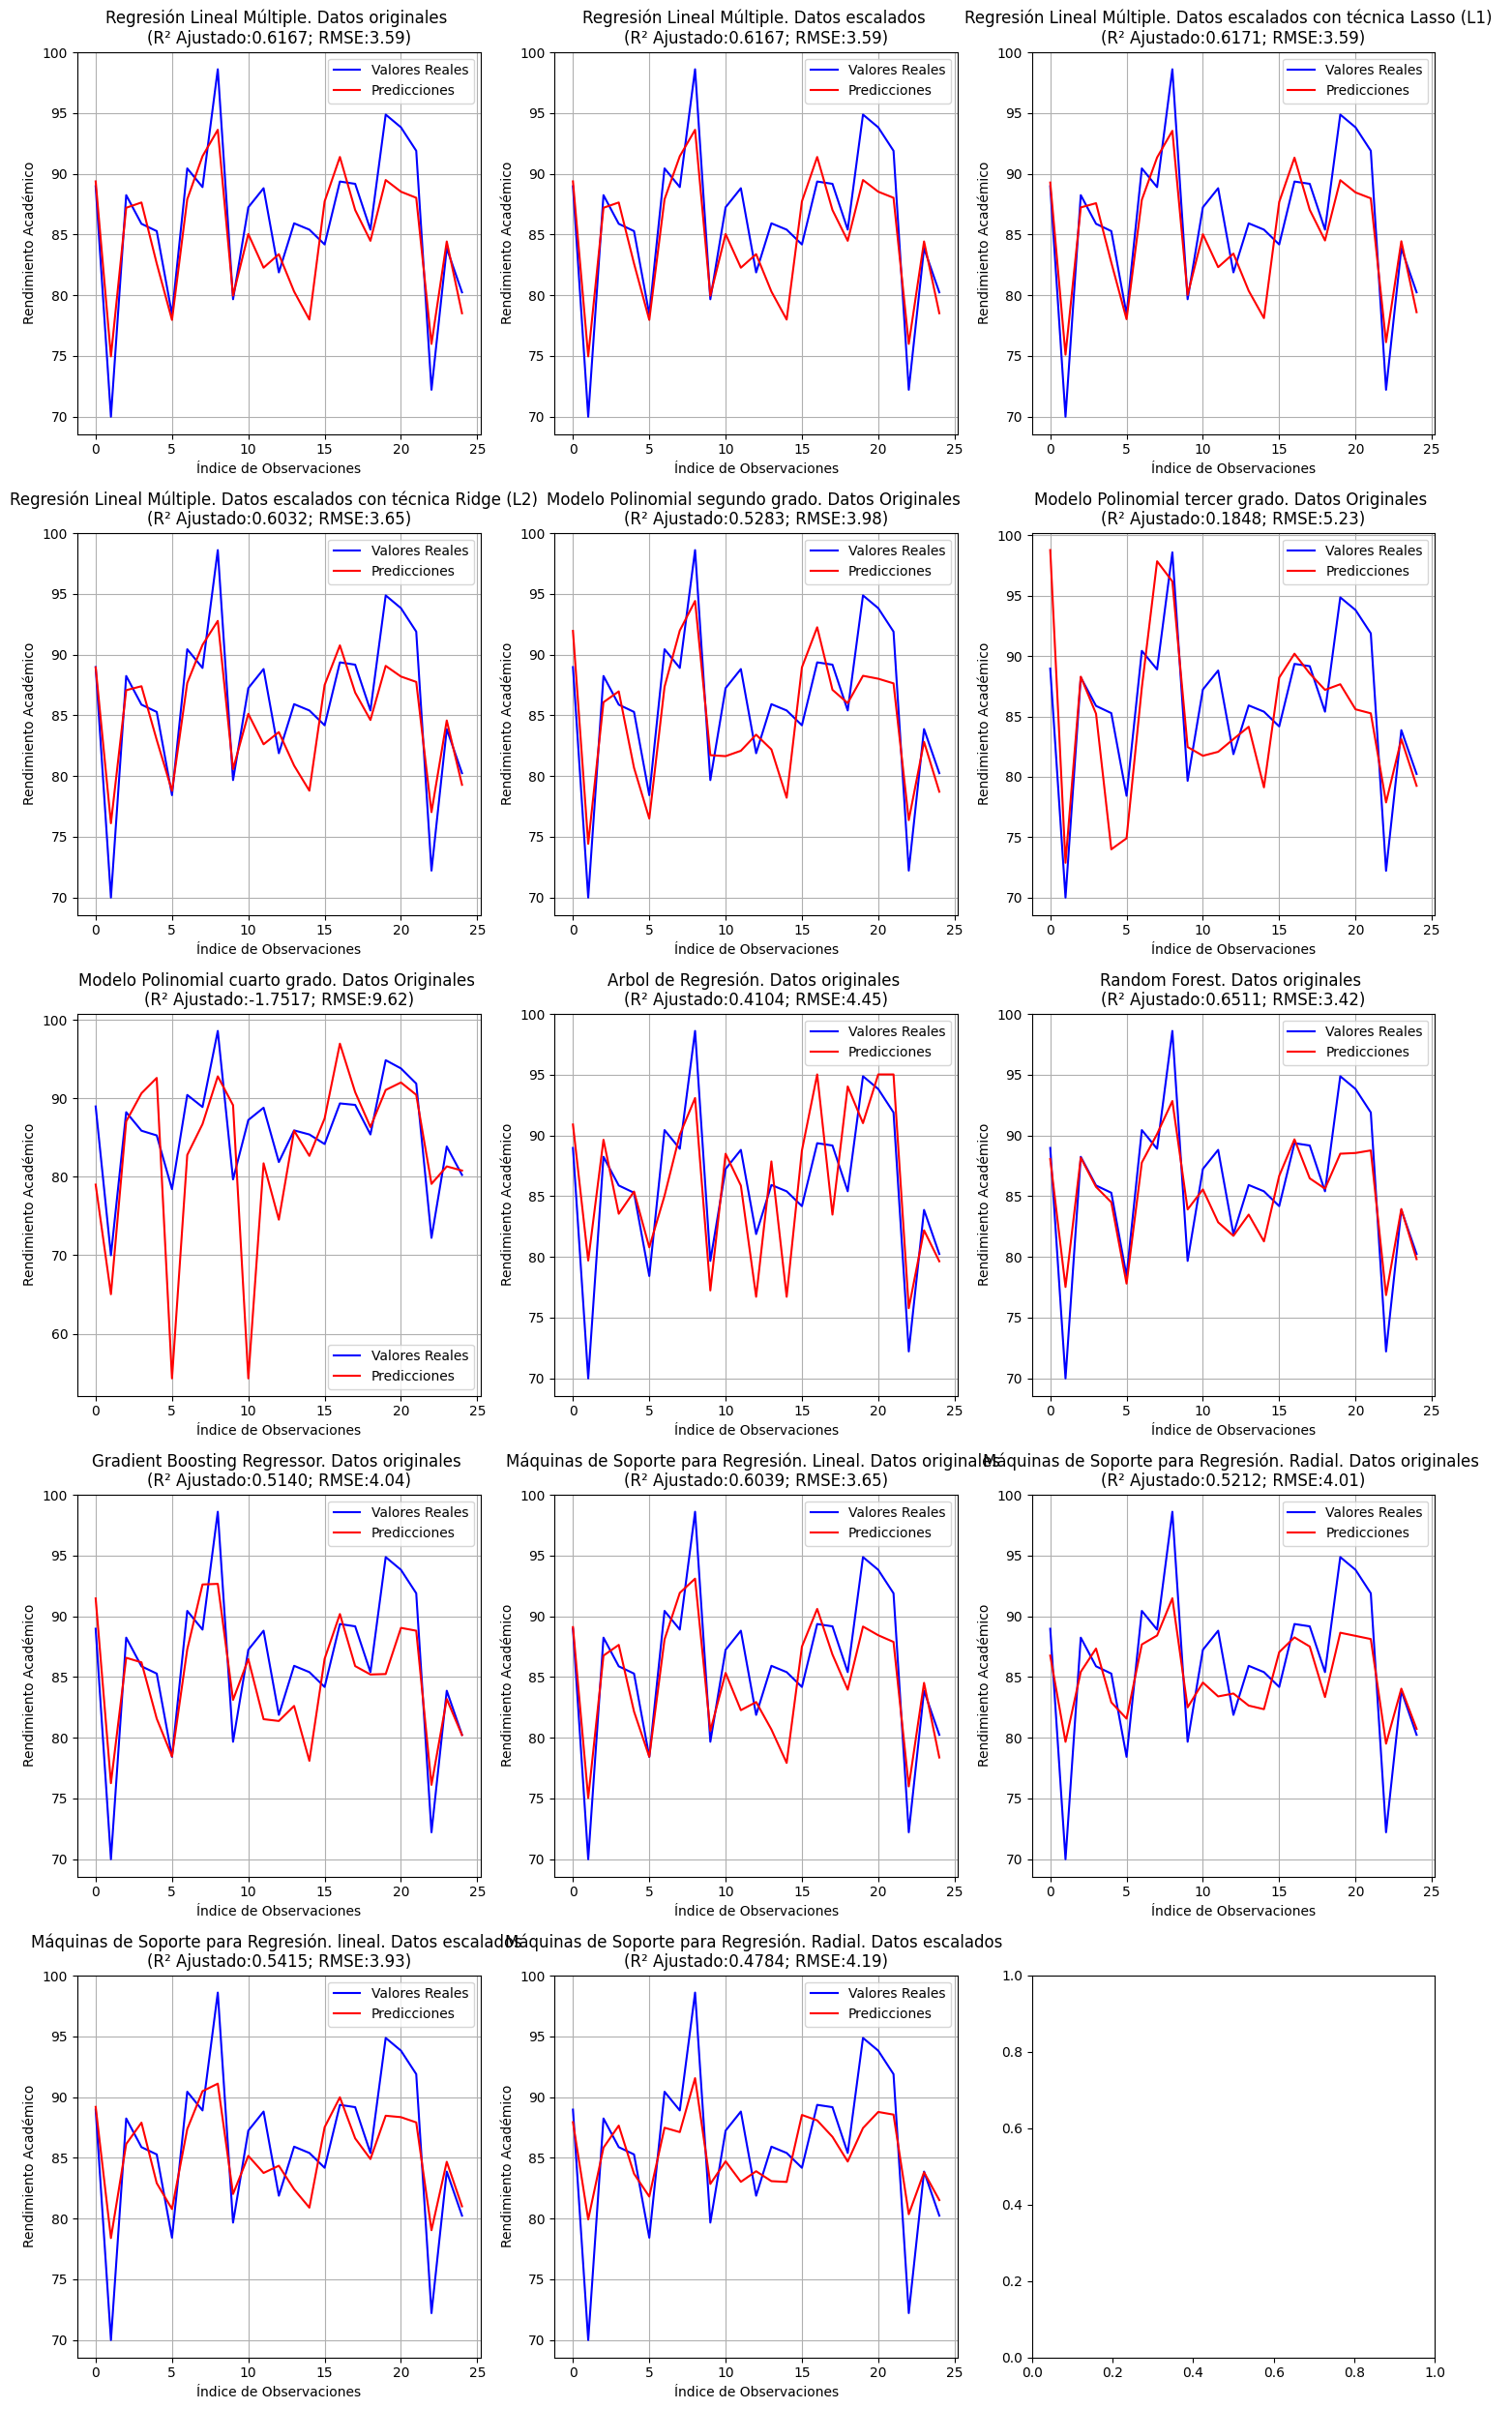

In [97]:


f_diferencias_matriz(gr_diferencias_predicciones)

# Interpretación del caso

Se cargaron datos de un contexto en donde existen variables independientes que representan valores numéricos de habilidades blandas de estudiantes y la influencia que tienen sobre el rendimiento académico escolar de los propios alumnos de educación superior.

Los modelos de regresión explican la variabilidad del rendimiento académico por encima del 50%.

El modelo de regresión con estos datos con mejor rendimiento fue ...*Random Forest*. El modelo fue construído con datos originales	y los estadísticos de evaluación resultantes fueron los siguientes: **MSE =	11.72,	RMSE = 3.42,	R² = 0.70,	R² Ajustado = 0.65**.






# Bibliografía